multivariate times series
regular times series
var model et non arima
verifier si stationnary
use referencing if not





In [1]:
#importing the libraries
import numpy as np
import pandas as pd
from datetime import datetime, timedelta, time
from vacances_scolaires_france import SchoolHolidayDates
import sys
from impyute.imputation.cs import mice
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [12.0, 8.0]
import seaborn as sns
#pip install vacances-scolaires-france
#pip3 install impyute
# my fonctions
def conv(data):
    data["date"] = data.timestamp.apply(lambda x : x.split('T')[0])
    data["datetime_perso"] = data.timestamp.apply(lambda x : get_format_the_date(x))
    data['year']=data['datetime_perso'].dt.year
    data['month']=data['datetime_perso'].dt.month
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    data['hours'] = data['timestamp'].dt.hour
    return data

## get season
def get_season(doy):
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    if doy in spring:
        season = 'spring'
    elif doy in summer:
      season = 'summer'
    elif doy in fall:
        season = 'fall'
    else:
        season = 'winter'
    return season

## verifie si jour ferie
def easter_date(year):
    a = year // 100
    b = year % 100
    c = (3 * (a + 25)) // 4
    d = (3 * (a + 25)) % 4
    e = (8 * (a + 11)) // 25
    f = (5 * a + b) % 19
    g = (19 * f + c - e) % 30
    h = (f + 11 * g) // 319
    j = (60 * (5 - d) + b) // 4
    k = (60 * (5 - d) + b) % 4
    m = (2 * j - k - g + h) % 7
    n = (g - h + m + 114) // 31
    p = (g - h + m + 114) % 31
    day = p + 1
    month = n
    return datetime(year, month, day)

def is_ferie(the_date):
    year = the_date.year
    easter = easter_date(year)
    days = [
        datetime(year, 1, 1),  # Premier de l'an
        easter + timedelta(days=1),  # Lundi de Pâques
        datetime(year, 5, 1),  # Fête du Travail
        datetime(year, 5, 8),  # Victoire de 1945
        easter + timedelta(days=39),  # Ascension
        easter + timedelta(days=49),  # Pentecôte
        datetime(year, 7, 14),  # Fête Nationale
        datetime(year, 8, 15),  # Assomption
        datetime(year, 11, 1),  # Toussaint
        datetime(year, 11, 11),  # Armistice 1918
        datetime(year, 12, 25),  # Noël
    ]
    return the_date in days

def get_format_the_date(timestamp):
    do = datetime.strptime(timestamp, '%Y-%m-%dT%H:%M:%S.%f')
    d5 = do.replace(minute=0, hour=0, second=0, microsecond=0).isoformat(' ')
    the_date = datetime.strptime(d5, "%Y-%m-%d %H:%M:%S")
    return the_date

def business_day(timestamp):
    if not is_ferie(timestamp) and timestamp.isoweekday() not in [6, 7]:
        return True
    else:
        return False
    
  

In [2]:
#Summary Statistics
def check_summary(series):
    """
    Split the series into two and check summary statistics for both the series
    """
    
    X = series.values
    split =int( len(X) / 2)
    X1, X2 = X[0:split], X[split:]
    meanoverall, mean1, mean2 = X.mean(), X1.mean(), X2.mean()
    varoverall, var1, var2 = X.var(), X1.var(), X2.var()
    print('mean overall = %f, \t mean1=%f, \t mean2=%f' % (meanoverall, mean1, mean2))
    print('variance overall= %f, \t variance1=%f, \t variance2=%f' % (varoverall, var1, var2))


#Distribution by plotting Histogram
def check_distribution(series):
    """
    Distribution by plotting Histogram
    """
    series.hist()
    plt.show()        


#Stationarity Check:
def check_stationarity(series):   
    """
    Check stationarity using ADF test
    Ho : The series is non-stationary and has a unit root --> p-value > 0.05
    H1 : The series is stationary and does not have a unit root --> p-value < 0.05
    """
   
    X = series.values
    result = adfuller(X)
    print('Test: Running ADF Stationarity test for {} \n\t ADF test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))

    print('\n\tCritical Values:')
    for key, value in result[4].items():
    	print('\t%s: %.3f' % (key, value))
    
    if result[4]['5%'] > result[0]:
        conclusion = 'Series is Stationary @95% CI'
        print ('\t Conclusion: Series is stationary at 95% CI\n')
    elif result[4]['10%'] > result[0]:
        conclusion = 'Series is Stationary @90% CI'
        print ('\t Conclusion: Series is stationary at 90% CI but non-stationary at 95% CI\n')
    else:
        conclusion = 'Series is non-Stationary'
        print ('\t Conclusion: Series is non-stationary\n')
    return conclusion
        
#Series Plots:
def check_plots(series):
    """
    Plots the series as a line chart
    """
    plt.plot(series)
    plt.show()        
    
def check_normality(series):
    result = stats.normaltest(series)
    
    print('Test: Running Agostino and Pearson Normality test for {} \n\t Normality test statistic: {} \n\t p-value: {} '.format(series.name, result[0], result[1]))
    
    if(result[1]< 0.05):
        conclusion = 'Not Normally Distributed'
        print('\t Conclusion: {} is not normally distributed at 95% CI \n'.format(series.name))
    else:
        conclusion = 'Normally Distributed'
        print('\t Conclusion: {} is normally distributed at 95% CI \n'.format(series.name))
        
    return conclusion 

In [3]:
def processing(dataInt):
    ## missing value
    df = dataInt.copy()
    #df_num = df.drop(['timestamp','loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    #df_NonNum = df.select_dtypes(include=[np.object])
    imputed_training_mice = mice(df.values)
    data_mice = pd.DataFrame(imputed_training_mice, columns = df.columns, index = list(df.index.values))
   # dClean = data_mice.join(df_NonNum)
    ## drop variable inutile
    #d_tr = dClean.drop(['loc_1', 'loc_2', 'loc_secondary_1', 'loc_secondary_2', 'loc_secondary_3'], axis=1)
    ## create extra attribute
    #conv(d_tr)
    #d_tr['timestamp'] = pd.to_datetime(d_tr.timestamp, format = '%Y-%m-%dT%H:%M:%S.%f')
    ## create season and rangeInYear
    #s = pd.to_datetime(pd.Series(d_tr['timestamp']))
    #d_tr['rangeInYear'] = s.dt.strftime('%j').astype(int)
    #create jours working days
   # d_tr['is_business_day'] = d_tr['datetime_perso'].apply(lambda e : int(business_day(e)))
    #Is it an holiday for zone A, B or C?
    #d = SchoolHolidayDates()
    #d_tr['is_holiday'] = d_tr['datetime_perso'].apply(lambda f : int(d.is_holiday(datetime.date(f))))
    #d_tr['season'] = d_tr['rangeInYear'].apply(lambda d : get_season(d))
    #dataInt1 = d_tr.drop(['rangeInYear', 'datetime_perso', 'date', 'timestamp'], axis=1)
    return (data_mice)  


--------------------------------------------------------------------------------------------------------------------

In [4]:
# creere un je
dataInt_raw = pd.read_csv('./data_set1/input_training_ssnsrY0.csv')
dataOut_raw = pd.read_csv('./data_set1/output_training_Uf11I9I.csv')
data = pd.concat([dataInt_raw, dataOut_raw], axis=1)
data.head()
data.columns
#----------------------


Index(['ID', 'timestamp', 'temp_1', 'temp_2', 'mean_national_temp',
       'humidity_1', 'humidity_2', 'loc_1', 'loc_2', 'loc_secondary_1',
       'loc_secondary_2', 'loc_secondary_3', 'consumption_secondary_1',
       'consumption_secondary_2', 'consumption_secondary_3', 'ID',
       'consumption_1', 'consumption_2'],
      dtype='object')

In [5]:
data.head(2)

ID              timestamp  temp_1  temp_2  mean_national_temp  humidity_1  \
0   0  2016-11-01T00:00:00.0     8.3     NaN                11.1        95.0   
1   1  2016-11-01T01:00:00.0     8.0     NaN                11.1        98.0   

   humidity_2            loc_1            loc_2   loc_secondary_1  \
0         NaN  (50.633, 3.067)  (43.530, 5.447)  (44.838, -0.579)   
1         NaN  (50.633, 3.067)  (43.530, 5.447)  (44.838, -0.579)   

    loc_secondary_2  loc_secondary_3  consumption_secondary_1  \
0  (47.478, -0.563)  (48.867, 2.333)                      143   
1  (47.478, -0.563)  (48.867, 2.333)                      141   

   consumption_secondary_2  consumption_secondary_3  ID  consumption_1  \
0                       74                      168   0            100   
1                       60                      162   1            101   

   consumption_2  
0             93  
1             94

In [6]:
data.describe()

ID       temp_1       temp_2  mean_national_temp   humidity_1  \
count  8760.000000  8589.000000  8429.000000         8760.000000  8589.000000   
mean   4379.500000    11.402771    15.086274           13.173858    77.351496   
std    2528.938512     7.049919     8.463627            6.474700    16.638173   
min       0.000000    -5.700000    -7.200000           -1.800000    21.000000   
25%    2189.750000     6.100000     9.000000            8.200000    66.000000   
50%    4379.500000    11.200000    14.500000           12.800000    81.000000   
75%    6569.250000    16.400000    21.000000           18.700000    91.000000   
max    8759.000000    33.600000    39.300000           28.300000   100.000000   

        humidity_2  consumption_secondary_1  consumption_secondary_2  \
count  8428.000000              8760.000000              8760.000000   
mean     63.443284               203.025114               123.581735   
std      21.900343                69.792811                65.036526   
min      12.000000                84.000000                 0.000000   
25%      46.000000               150.000000                73.000000   
50%      65.000000               181.000000               107.000000   
75%      83.000000               252.000000               160.000000   
max      99.000000               464.000000               355.000000   

       consumption_secondary_3           ID  consumption_1  consumption_2  
count              8760.000000  8760.000000    8760.000000    8760.000000  
mean                235.774201  4379.500000     137.549543     148.529909  
std                  99.701896  2528.938512      63.146689      73.263972  
min                  94.000000     0.000000      38.000000       0.000000  
25%                 166.000000  2189.750000      91.000000     105.000000  
50%                 194.000000  4379.500000     116.000000     129.000000  
75%                 287.250000  6569.250000     176.000000     181.000000  
max                 570.000000  8759.000000     349.000000     542.000000

In [7]:
data['timestamp'] = pd.to_datetime(data['timestamp'])

In [8]:
data.set_index('timestamp', inplace=True)

In [9]:
data.head()

ID  temp_1  temp_2  mean_national_temp  humidity_1  \
timestamp                                                                 
2016-11-01 00:00:00   0     8.3     NaN                11.1        95.0   
2016-11-01 01:00:00   1     8.0     NaN                11.1        98.0   
2016-11-01 02:00:00   2     6.8     NaN                11.0        97.0   
2016-11-01 03:00:00   3     7.5     NaN                10.9        99.0   
2016-11-01 04:00:00   4     6.1     NaN                10.8        98.0   

                     humidity_2            loc_1            loc_2  \
timestamp                                                           
2016-11-01 00:00:00         NaN  (50.633, 3.067)  (43.530, 5.447)   
2016-11-01 01:00:00         NaN  (50.633, 3.067)  (43.530, 5.447)   
2016-11-01 02:00:00         NaN  (50.633, 3.067)  (43.530, 5.447)   
2016-11-01 03:00:00         NaN  (50.633, 3.067)  (43.530, 5.447)   
2016-11-01 04:00:00         NaN  (50.633, 3.067)  (43.530, 5.447)   

                      loc_secondary_1   loc_secondary_2  loc_secondary_3  \
timestamp                                                                  
2016-11-01 00:00:00  (44.838, -0.579)  (47.478, -0.563)  (48.867, 2.333)   
2016-11-01 01:00:00  (44.838, -0.579)  (47.478, -0.563)  (48.867, 2.333)   
2016-11-01 02:00:00  (44.838, -0.579)  (47.478, -0.563)  (48.867, 2.333)   
2016-11-01 03:00:00  (44.838, -0.579)  (47.478, -0.563)  (48.867, 2.333)   
2016-11-01 04:00:00  (44.838, -0.579)  (47.478, -0.563)  (48.867, 2.333)   

                     consumption_secondary_1  consumption_secondary_2  \
timestamp                                                               
2016-11-01 00:00:00                      143                       74   
2016-11-01 01:00:00                      141                       60   
2016-11-01 02:00:00                      142                       60   
2016-11-01 03:00:00                      139                       60   
2016-11-01 04:00:00                      154                       60   

                     consumption_secondary_3  ID  consumption_1  consumption_2  
timestamp                                                                       
2016-11-01 00:00:00                      168   0            100             93  
2016-11-01 01:00:00                      162   1            101             94  
2016-11-01 02:00:00                      164   2            100             96  
2016-11-01 03:00:00                      162   3            101             95  
2016-11-01 04:00:00                      164   4            100            100

In [10]:
data = data.loc[:, ['temp_1', 'temp_2','mean_national_temp', 'humidity_1', 'humidity_2', 
                              'consumption_secondary_1', 'consumption_secondary_2', 'consumption_secondary_3','consumption_1','consumption_2']]


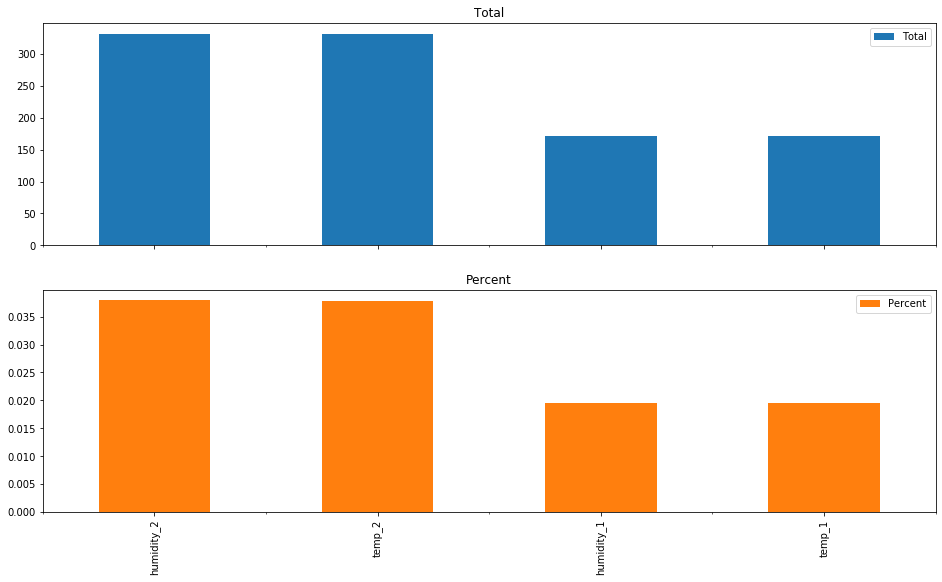

In [11]:
def list_and_visualize_missing_data(dataset):
    # Listing total null items and its percent with respect to all nulls
    total = dataset.isnull().sum().sort_values(ascending=False)
    percent = ((dataset.isnull().sum())/(dataset.isnull().count())).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    missing_data = missing_data[missing_data.Total > 0]
    missing_data.plot.bar(subplots=True, figsize=(16,9))
list_and_visualize_missing_data(data)

In [12]:
data1 = processing(data)

In [13]:
data1.columns

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [14]:
data1.head(2)

temp_1     temp_2  mean_national_temp  humidity_1  \
2016-11-01 00:00:00     8.3  11.103591                11.1        95.0   
2016-11-01 01:00:00     8.0  10.712156                11.1        98.0   

                     humidity_2  consumption_secondary_1  \
2016-11-01 00:00:00   75.598986                    143.0   
2016-11-01 01:00:00   77.150098                    141.0   

                     consumption_secondary_2  consumption_secondary_3  \
2016-11-01 00:00:00                     74.0                    168.0   
2016-11-01 01:00:00                     60.0                    162.0   

                     consumption_1  consumption_2  
2016-11-01 00:00:00          100.0           93.0  
2016-11-01 01:00:00          101.0           94.0

In [15]:
data1.dtypes

temp_1                     float64
temp_2                     float64
mean_national_temp         float64
humidity_1                 float64
humidity_2                 float64
consumption_secondary_1    float64
consumption_secondary_2    float64
consumption_secondary_3    float64
consumption_1              float64
consumption_2              float64
dtype: object

In [16]:
data1.index.dtype

dtype('<M8[ns]')

In [17]:
data1.index = pd.to_datetime(data.index)
data1.index

DatetimeIndex(['2016-11-01 00:00:00', '2016-11-01 01:00:00',
               '2016-11-01 02:00:00', '2016-11-01 03:00:00',
               '2016-11-01 04:00:00', '2016-11-01 05:00:00',
               '2016-11-01 06:00:00', '2016-11-01 07:00:00',
               '2016-11-01 08:00:00', '2016-11-01 09:00:00',
               ...
               '2017-10-31 14:00:00', '2017-10-31 15:00:00',
               '2017-10-31 16:00:00', '2017-10-31 17:00:00',
               '2017-10-31 18:00:00', '2017-10-31 19:00:00',
               '2017-10-31 20:00:00', '2017-10-31 21:00:00',
               '2017-10-31 22:00:00', '2017-10-31 23:00:00'],
              dtype='datetime64[ns]', name='timestamp', length=8760, freq=None)

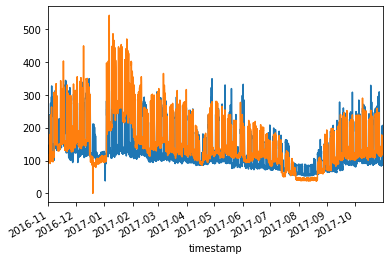

In [18]:
data1['consumption_1'].plot()
data1['consumption_2'].plot()

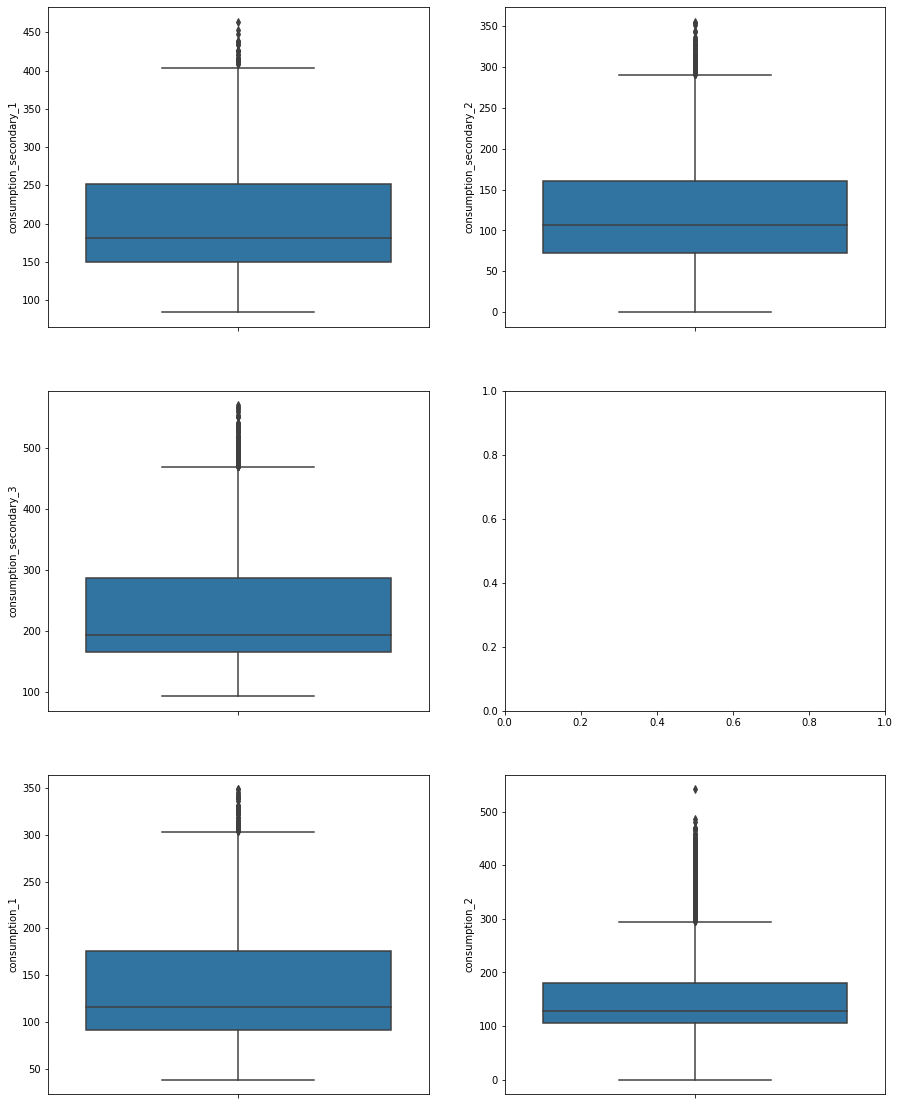

In [19]:
fig, axes = plt.subplots(nrows=3,ncols=2)
fig.set_size_inches(15, 20)
sns.boxplot(data=data1,y="consumption_secondary_1",orient="v",ax=axes[0][0])
sns.boxplot(data=data1,y="consumption_secondary_2",orient="v",ax=axes[0][1])
sns.boxplot(data=data1,y="consumption_secondary_3",orient="v",ax=axes[1][0])
sns.boxplot(data=data1,y="consumption_1",orient="v",ax=axes[2][0])
sns.boxplot(data=data1,y="consumption_2",orient="v",ax=axes[2][1])

In [20]:
cols_plot = data1.columns

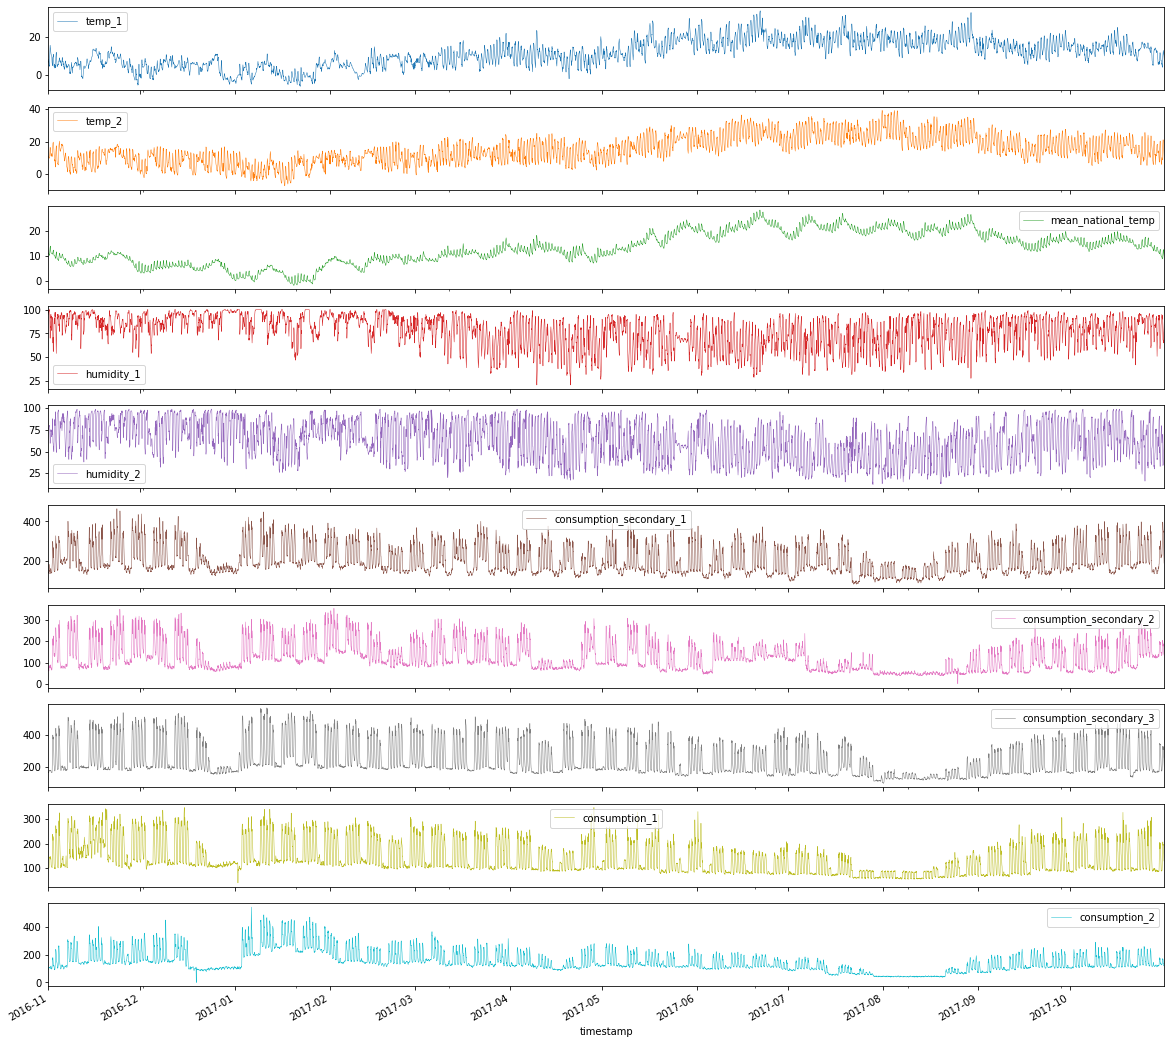

In [21]:
axes = data1[cols_plot].plot(alpha=1., linewidth=.5, figsize=(20, 20), subplots=True, sharex=True)

In [22]:
import plotly
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)

In [23]:
groupBy_whole = data1.groupby('timestamp').mean()


trace1 = go.Scatter(
        x=groupBy_whole.temp_1.index, 
        y=groupBy_whole.temp_1, 
        mode = 'lines',
        name = 'temp_1',
        marker = dict(color = 'rgba(0, 191, 205, 0.4)'))
trace2 = go.Scatter(
        x=groupBy_whole.temp_2.index, 
        y=groupBy_whole.temp_2, 
        mode = 'lines',
        name = 'temp_2',
        marker = dict(color = 'rgba(1, 50, 2, 0.2)'))
trace3 = go.Scatter(
        x=groupBy_whole.mean_national_temp.index, 
        y=groupBy_whole.mean_national_temp, 
        mode = 'lines',
        name = 'mean_national_temp',
        marker = dict(color = 'rgba(0, 61, 80, 0.6)'))

data = [trace1, trace2, trace3]

# layout=dict(title="Time Series Plot for Mean Daily temperature", xaxis={'title':'Date'}, yaxis={'title':'Temp/Humidity'})
layout = dict(
    title="Time Series Plot for Mean Daily temperature",
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=4,
                     label='4m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    ),
    yaxis={'title':'Temp/Humidity'}
)
fig=dict(data=data,layout=layout)
iplot(fig)

In [24]:
#define function for ADF test
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [25]:
#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [26]:
def tsplot(y, title, lags=None, figsize=(10, 6)):
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))

    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=12, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    sm.tsa.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    sm.tsa.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    sns.despine()
    plt.tight_layout()
    plt.show()
    return ts_ax, acf_ax, pacf_ax

In [27]:
import statsmodels.api as sm
import statsmodels.api as sm
import matplotlib

**TEMP_1 ---> Difference Stationary**

adf -> TS <  critical => stationnary, p-value => staionnary


kpss -> TS > critical => not stationnary

In [28]:
adf_test(data1['temp_1'])
kpss_test(data1['temp_1'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.565733
p-value                           0.006451
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           14.788216
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



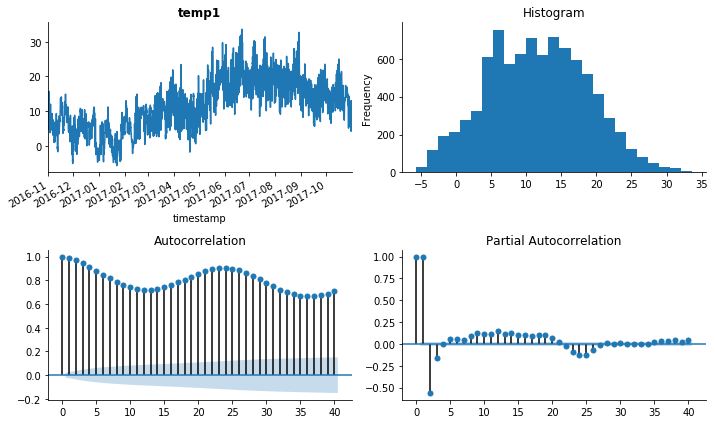

Text(0.5, 0, 'Year')

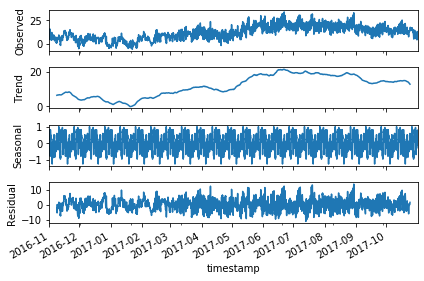

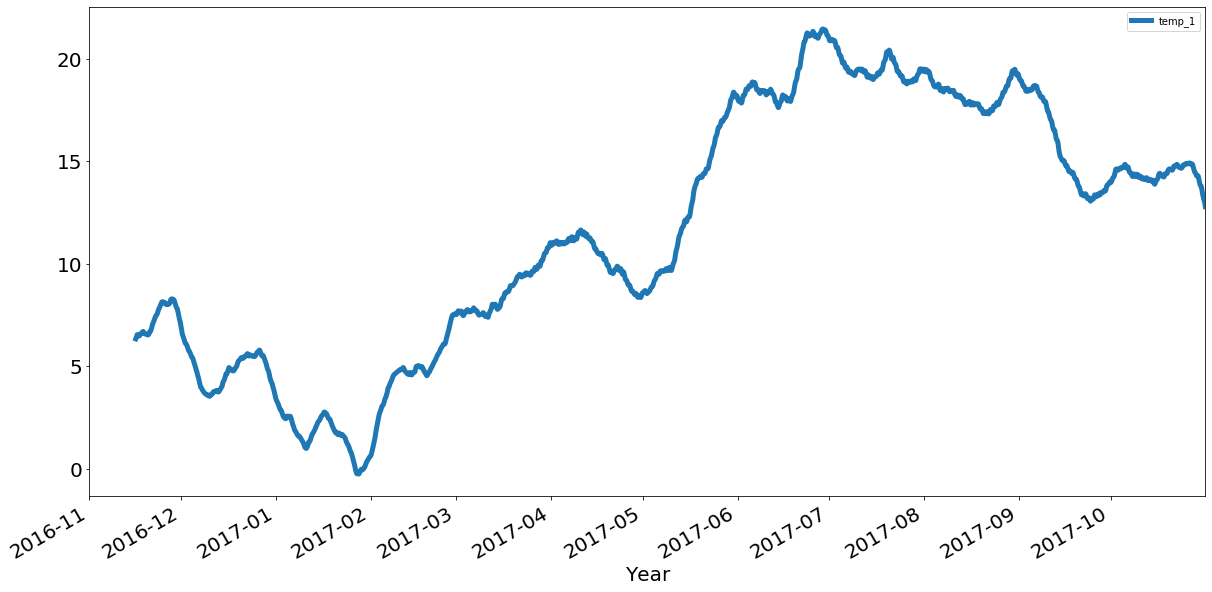

In [29]:
tsplot(data1['temp_1'], title='temp1')
decomposition  =sm.tsa.seasonal_decompose(data1['temp_1'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
temp1 = data1[['temp_1']]
temp1.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**TEMP_2 ---> Difference Stationary**

adf -> TS <  critical => stationnary, p_value stationnary

kpss -> TS > critical => not stationnary

In [30]:
adf_test(data1['temp_2'])
kpss_test(data1['temp_2'])

Results of Dickey-Fuller Test:
Test Statistic                   -3.368983
p-value                           0.012063
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           14.317102
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



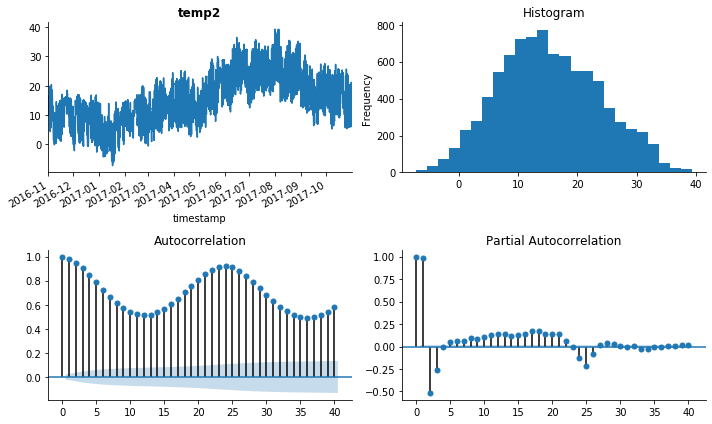

Text(0.5, 0, 'Year')

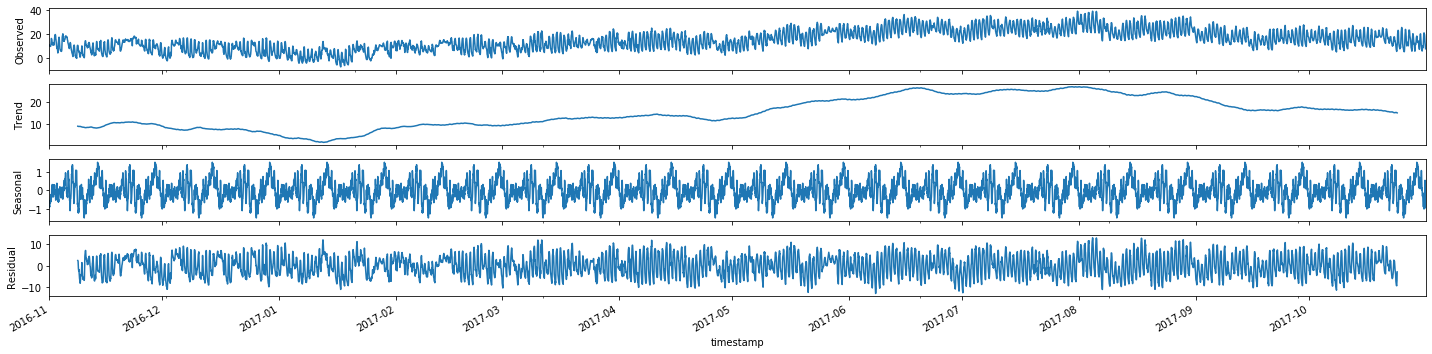

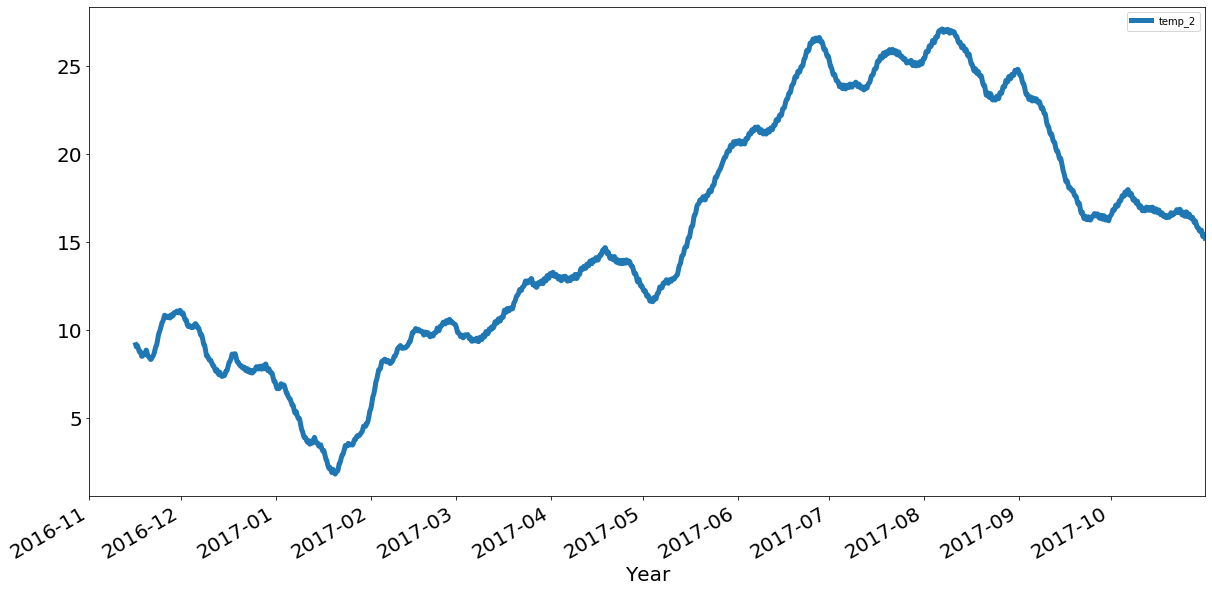

In [31]:
tsplot(data1['temp_2'], title='temp2')
decomposition  =sm.tsa.seasonal_decompose(data1['temp_2'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
temp2 = data1[['temp_2']]
temp2.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**Mean_national_temp ---> ?**

adf -> TS >  critical => not stationnary, pvalue=> not stationary

kpss -> TS > critical => not stationnary

In [32]:
adf_test(data1['mean_national_temp'])
kpss_test(data1['mean_national_temp'])

Results of Dickey-Fuller Test:
Test Statistic                   -2.307181
p-value                           0.169663
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           15.766045
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning:

invalid value encountered in sqrt



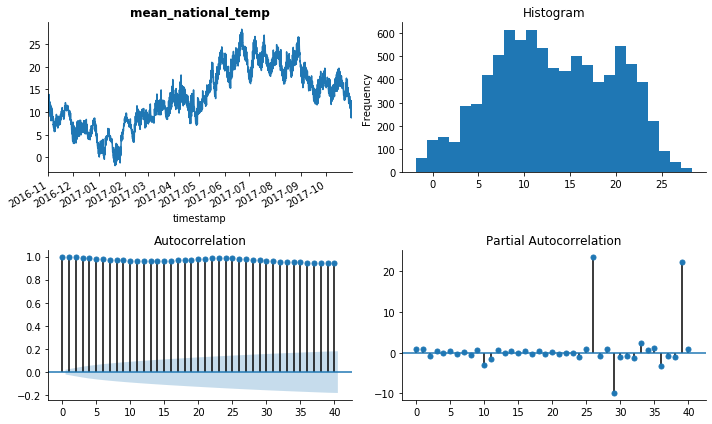

Text(0.5, 0, 'Year')

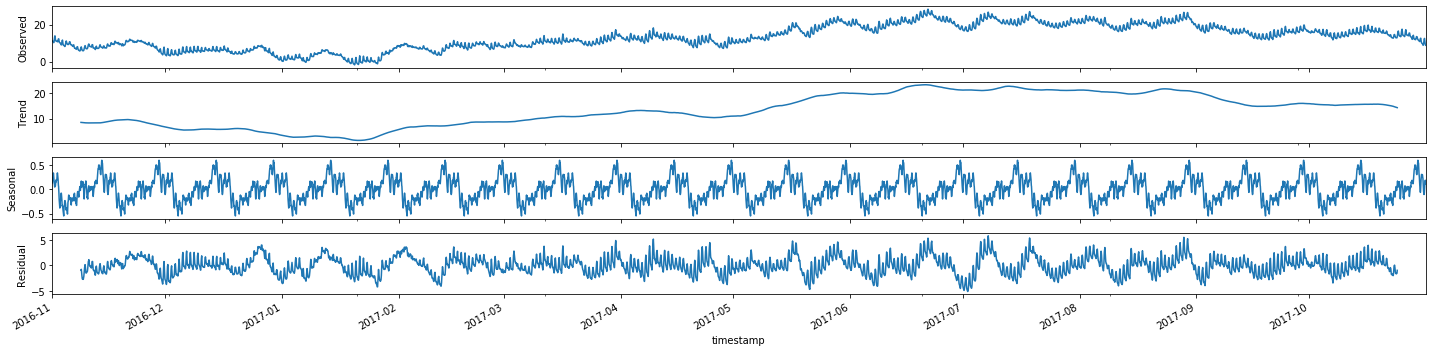

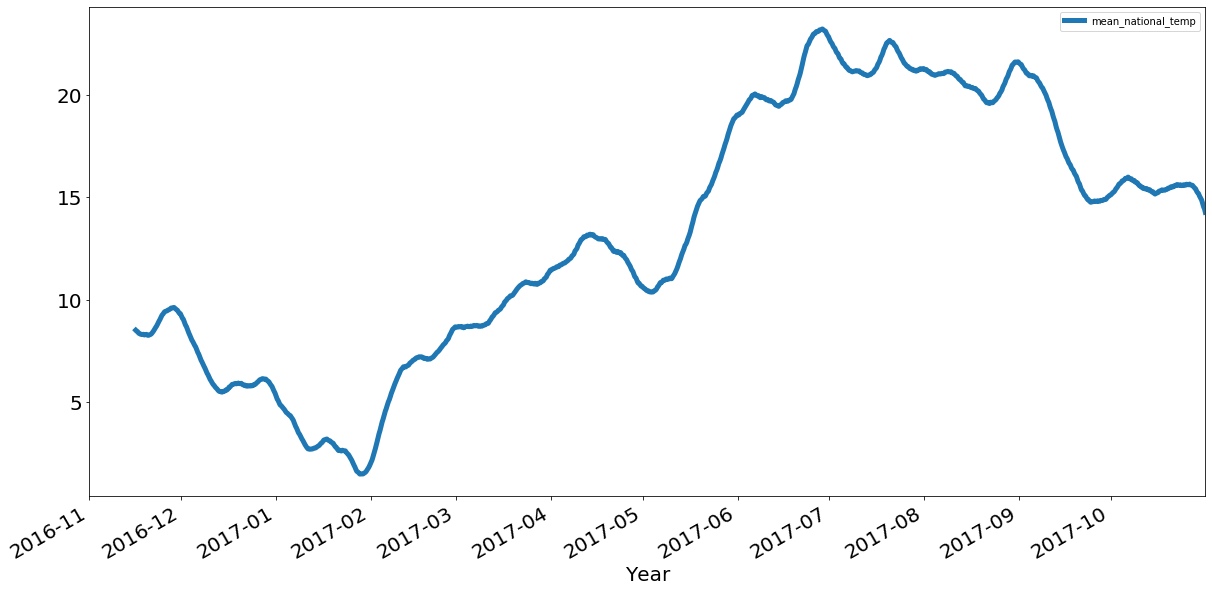

In [33]:
tsplot(data1['mean_national_temp'], title='mean_national_temp')
decomposition  =sm.tsa.seasonal_decompose(data1['mean_national_temp'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
mnt = data1[['mean_national_temp']]
mnt.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**Humidity_1 ---> Difference Stationary**

adf -> TS <  critical =>  stationnary, pvalue => staionary

kpss -> TS > critical => not stationnary

In [34]:
adf_test(data1['humidity_1'])
kpss_test(data1['humidity_1'])

Results of Dickey-Fuller Test:
Test Statistic                -7.121628e+00
p-value                        3.709626e-10
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            7.234414
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



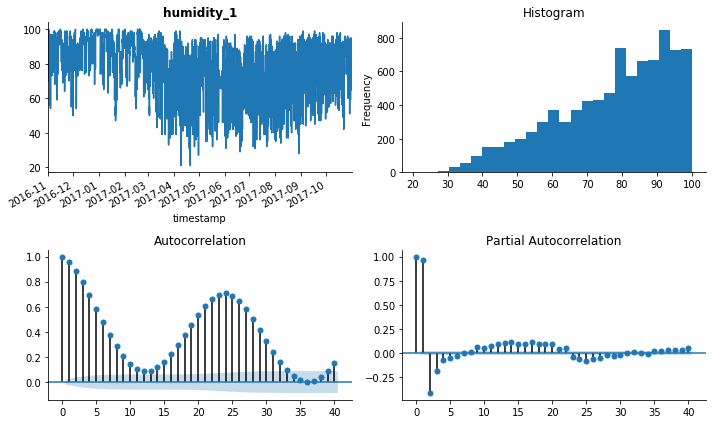

Text(0.5, 0, 'Year')

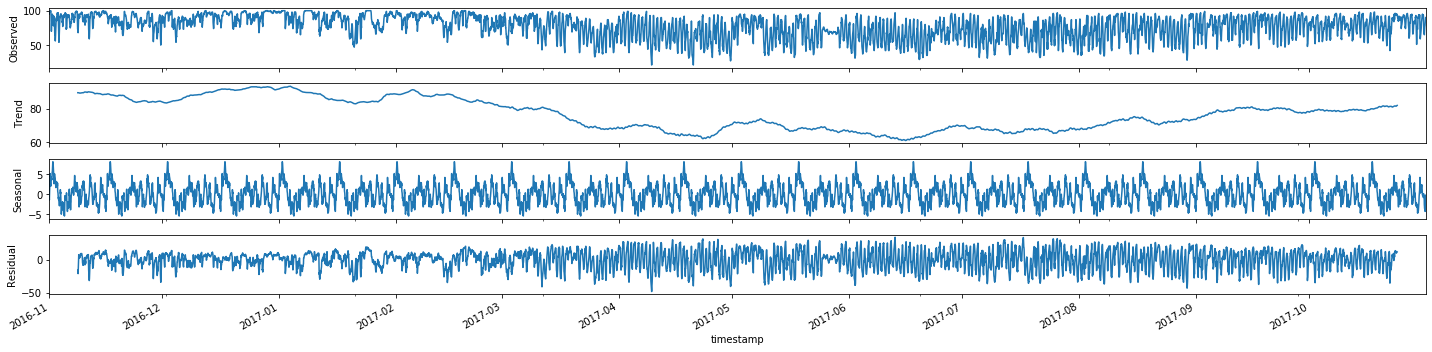

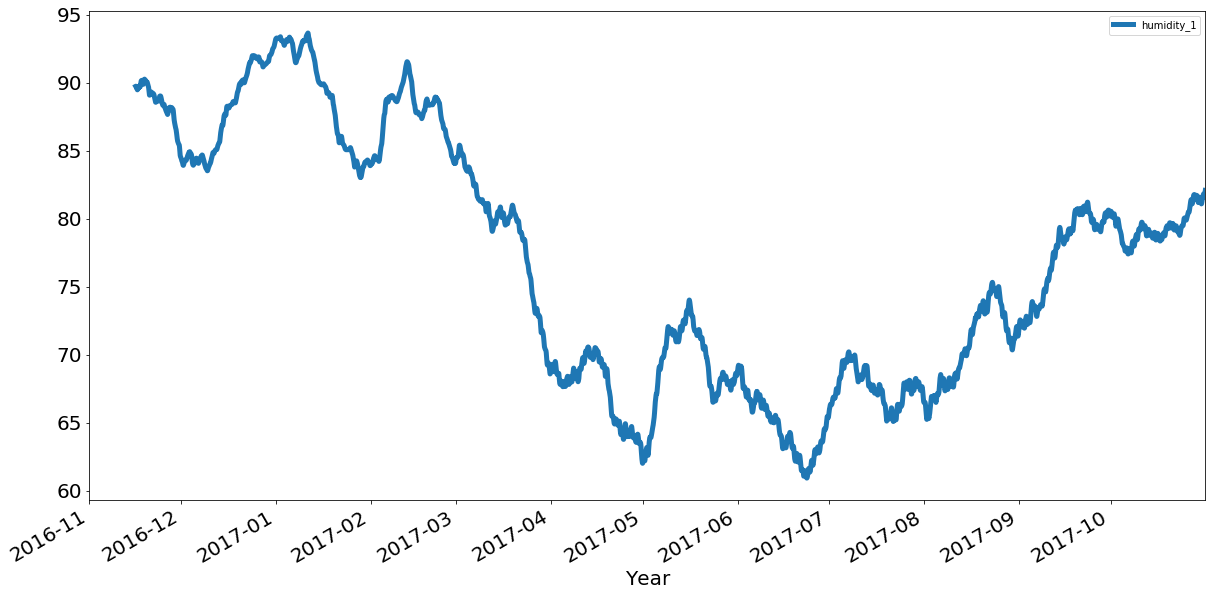

In [35]:
tsplot(data1['humidity_1'], title='humidity_1')
decomposition  =sm.tsa.seasonal_decompose(data1['humidity_1'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
hum1 = data1[['humidity_1']]
hum1.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**Humidity_2 ---> Difference Stationary**

adf -> TS < critical => stationnary, pa value stationary

kpss -> TS > critical => not stationnary


In [36]:
adf_test(data1['humidity_2'])
kpss_test(data1['humidity_2'])

Results of Dickey-Fuller Test:
Test Statistic                -7.686862e+00
p-value                        1.453836e-11
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            8.448472
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



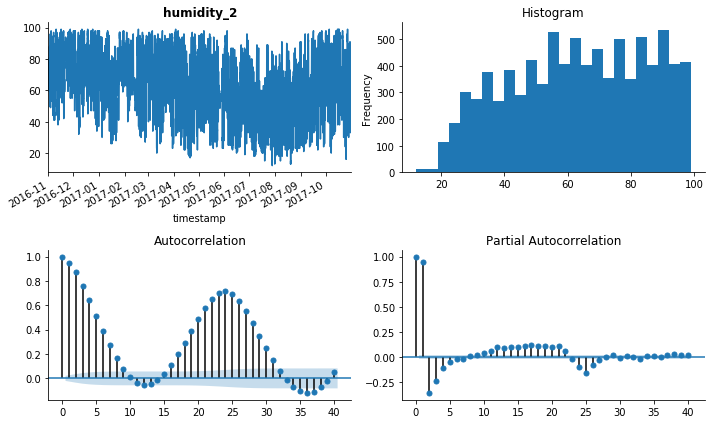

Text(0.5, 0, 'Year')

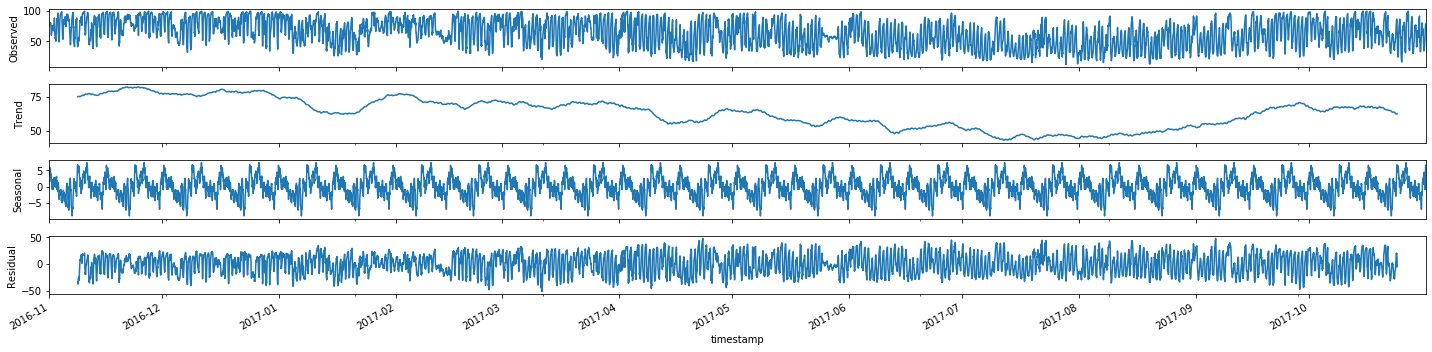

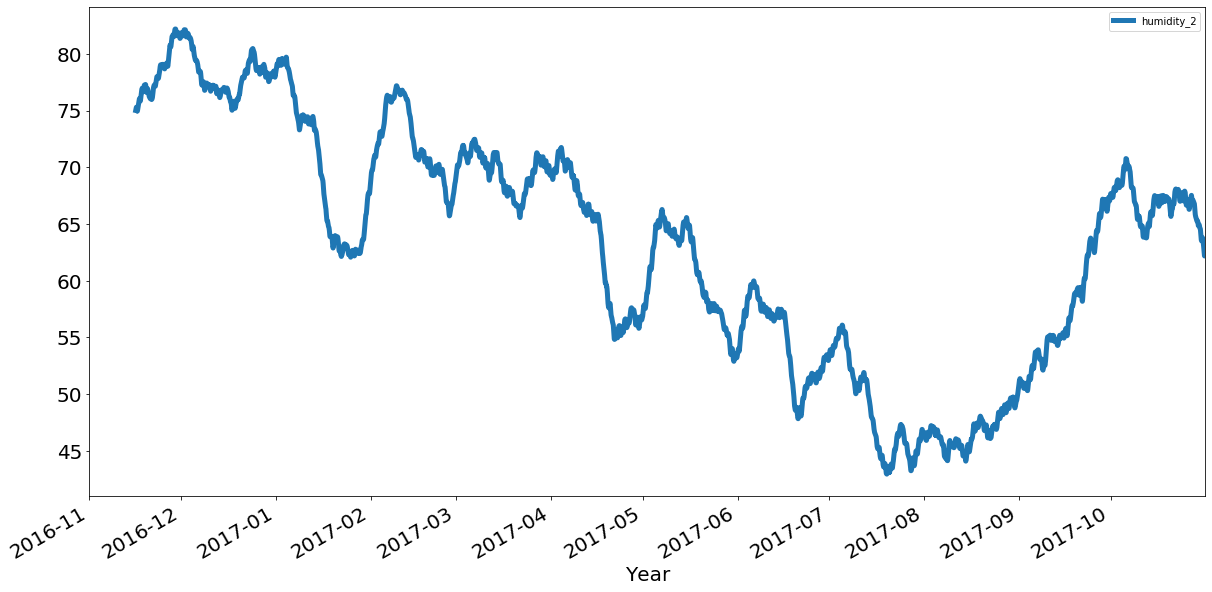

In [37]:
tsplot(data1['humidity_2'], title='humidity_2')
decomposition  =sm.tsa.seasonal_decompose(data1['humidity_2'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
hum2 = data1[['humidity_2']]
hum2.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**'consumption_secondary_1' --->diffrence**

adf -> TS > critical => stationnary, pvalue tionnary

kpss -> TS > critical => not stationnary


In [38]:
adf_test(data1['consumption_secondary_1'])
kpss_test(data1['consumption_secondary_1'])

Results of Dickey-Fuller Test:
Test Statistic                -1.094177e+01
p-value                        9.257566e-20
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            2.509934
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



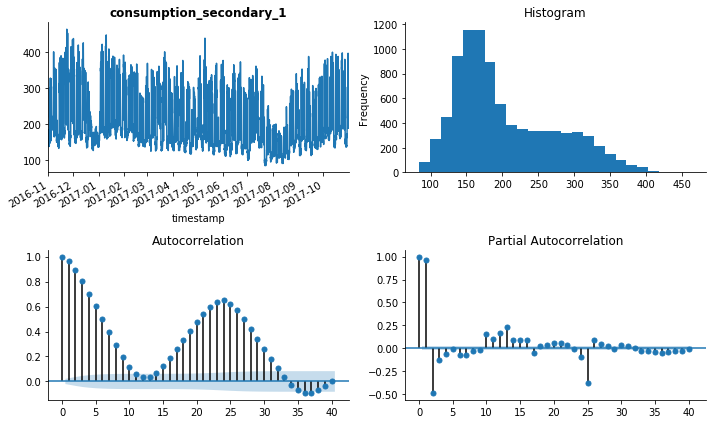

Text(0.5, 0, 'Year')

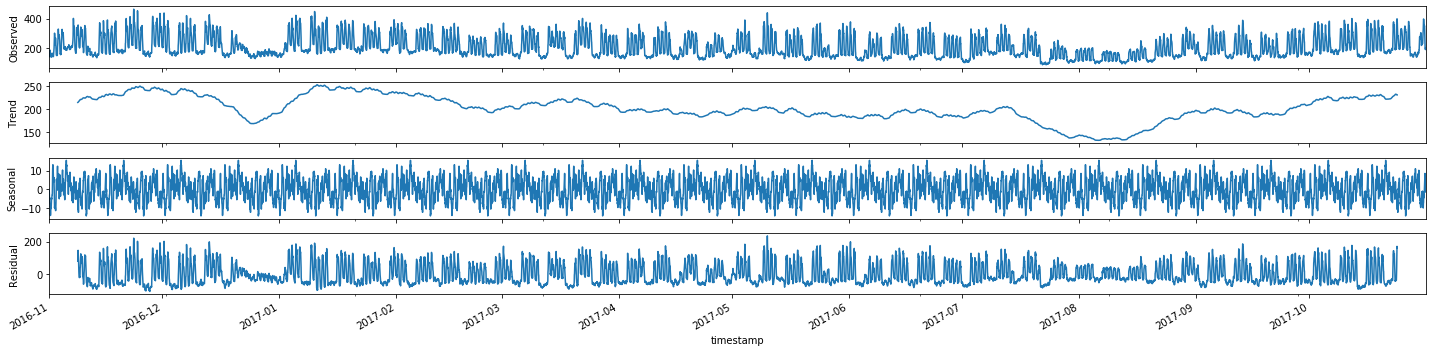

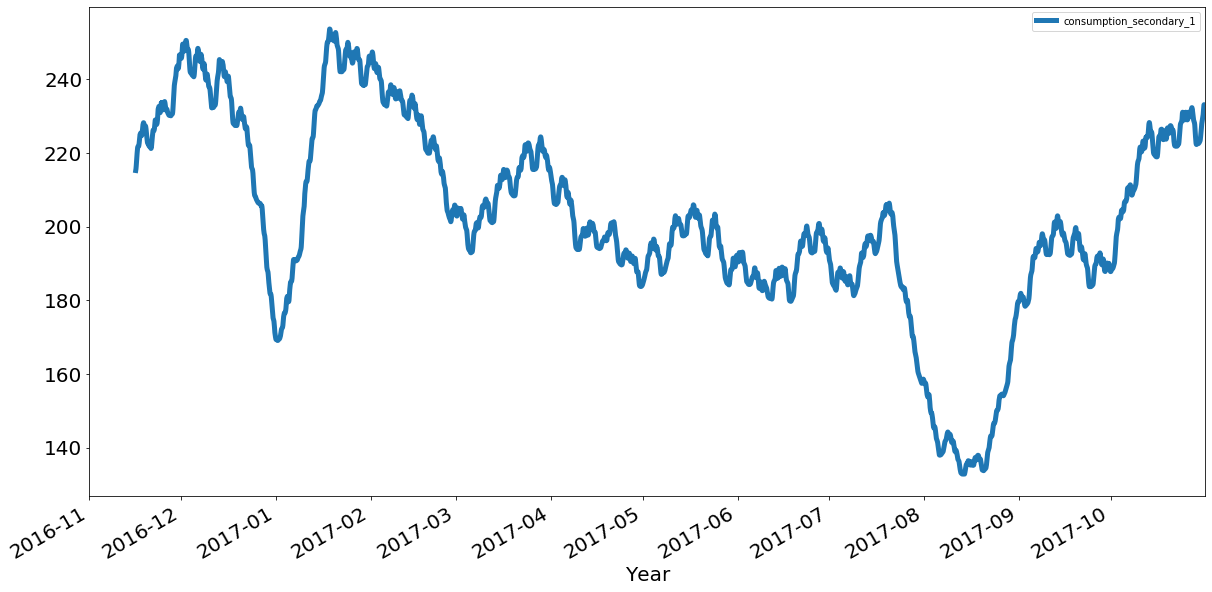

In [39]:
tsplot(data1['consumption_secondary_1'], title='consumption_secondary_1')
decomposition  =sm.tsa.seasonal_decompose(data1['consumption_secondary_1'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = data1[['consumption_secondary_1']]
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**'consumption_secondary_2' --->differencing**

adf -> TS < critical => stationnary, p_value => stationnary

kpss -> TS > critical => not stationnary


In [40]:
adf_test(data1['consumption_secondary_2'])
kpss_test(data1['consumption_secondary_2'])

Results of Dickey-Fuller Test:
Test Statistic                -8.455478e+00
p-value                        1.619259e-13
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            5.074619
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



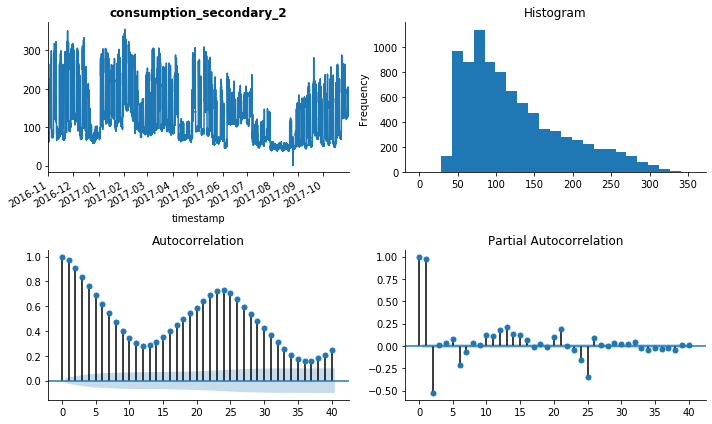

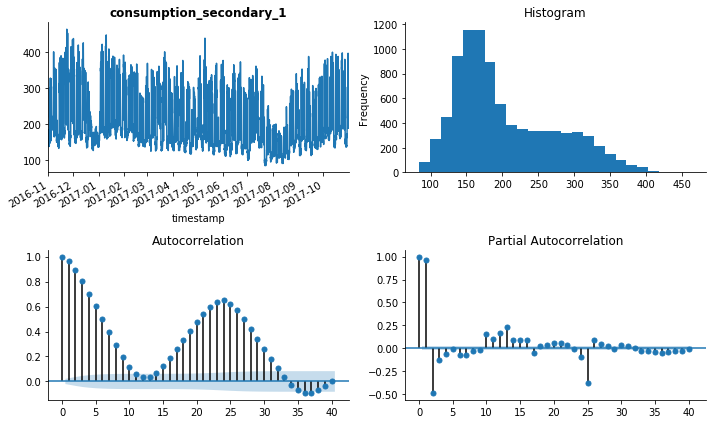

Text(0.5, 0, 'Year')

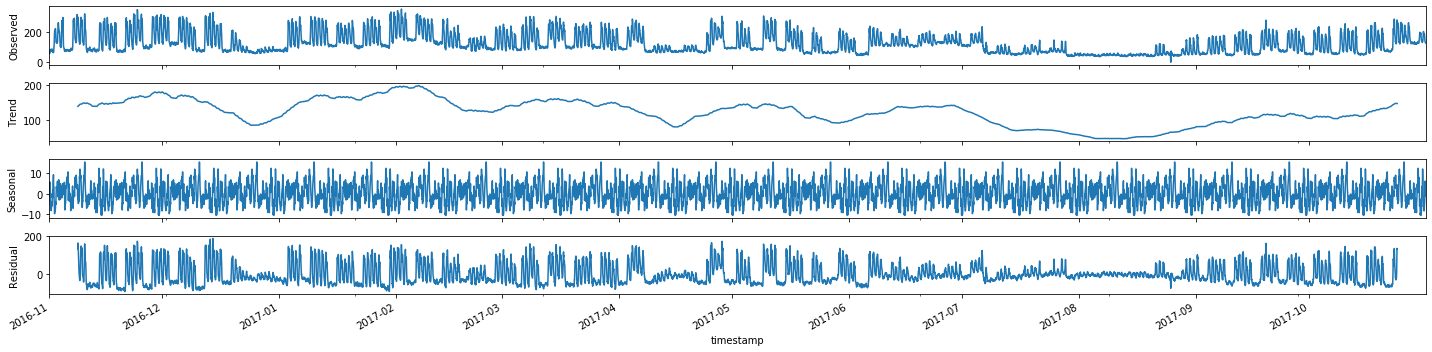

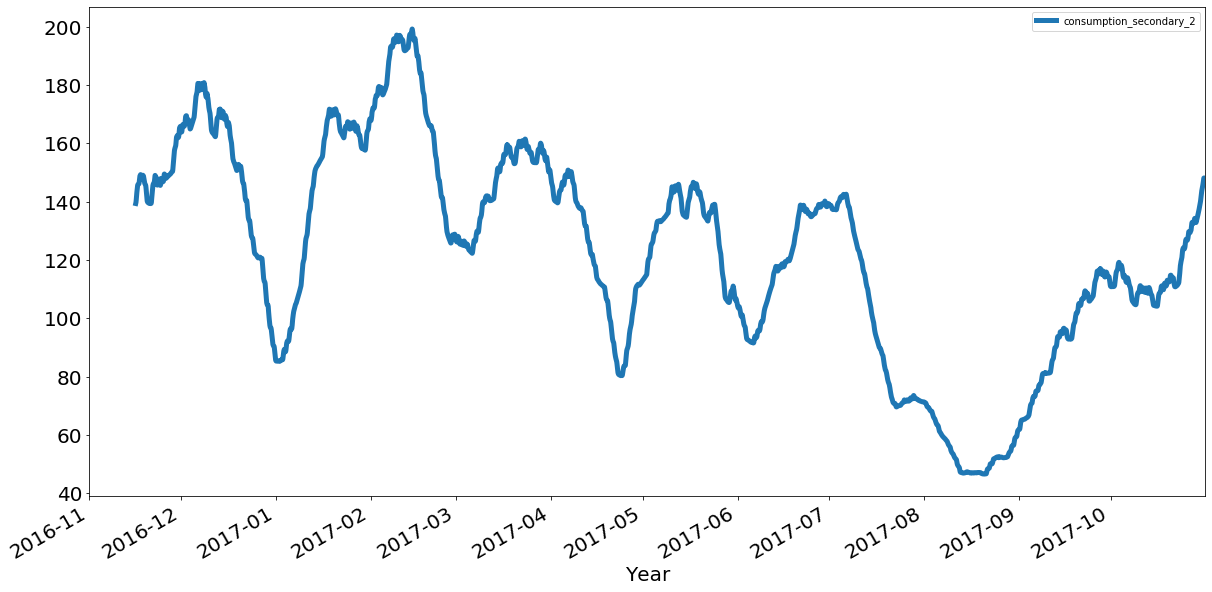

In [41]:
tsplot(data1['consumption_secondary_2'], title='consumption_secondary_2')
tsplot(data1['consumption_secondary_1'], title='consumption_secondary_1')
decomposition  =sm.tsa.seasonal_decompose(data1['consumption_secondary_2'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = data1[['consumption_secondary_2']]
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**'consumption_secondary_3' --->differencing**

adf -> TS < critical => stationnary, pvalue=. stionnary

kpss -> TS > critical => not stationnary


In [42]:
adf_test(data1['consumption_secondary_3'])
kpss_test(data1['consumption_secondary_3'])

Results of Dickey-Fuller Test:
Test Statistic                -9.555919e+00
p-value                        2.499232e-16
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            5.220702
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



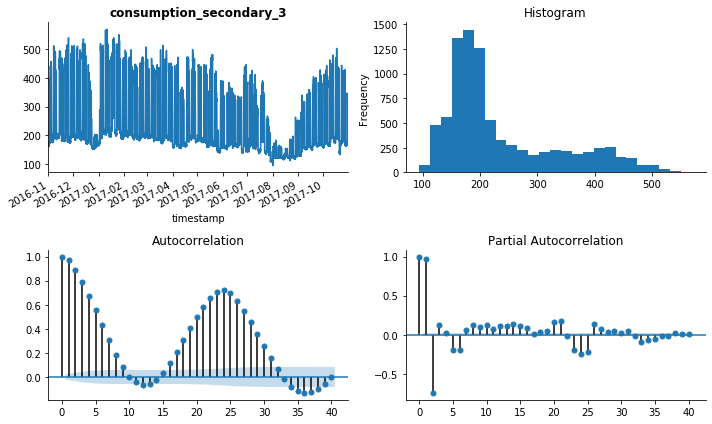

Text(0.5, 0, 'Year')

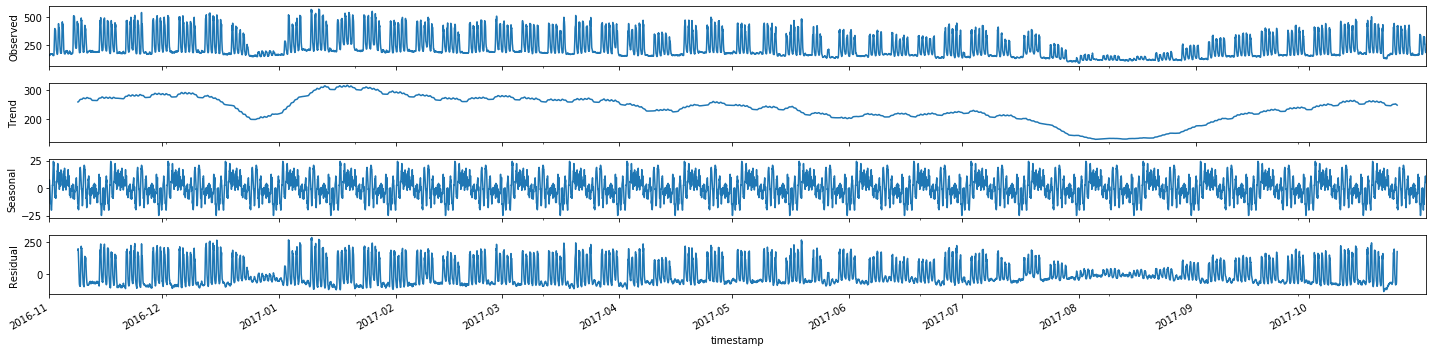

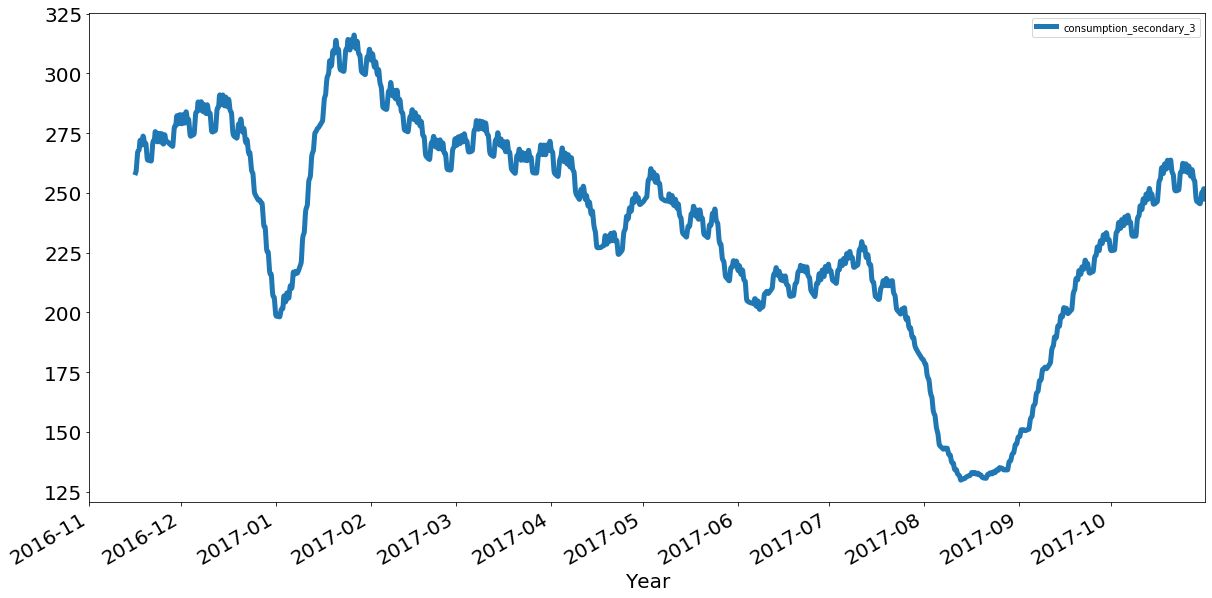

In [43]:
tsplot(data1['consumption_secondary_3'], title='consumption_secondary_3')
decomposition  =sm.tsa.seasonal_decompose(data1['consumption_secondary_3'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = data1[['consumption_secondary_3']]
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**'consumption_1' --->differencing**

adf -> TS < critical => stationnary, pvalue => stionary

kpss -> TS > critical => not stationnary


In [44]:
adf_test(data1['consumption_1'])
kpss_test(data1['consumption_1'])

Results of Dickey-Fuller Test:
Test Statistic                -8.125894e+00
p-value                        1.123480e-12
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            8.00514
p-value                   0.01000
Lags Used                37.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



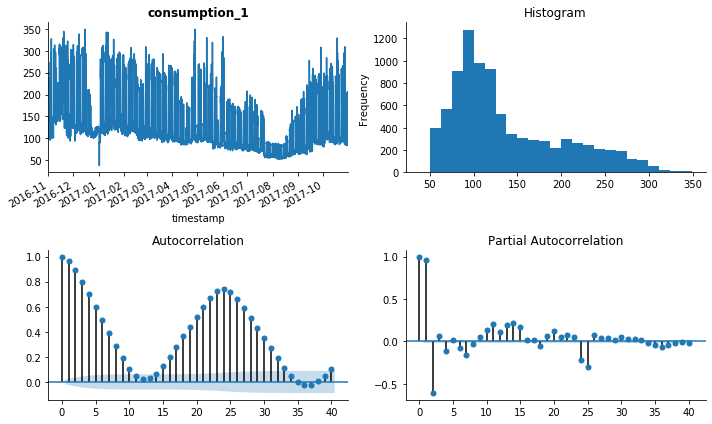

Text(0.5, 0, 'Year')

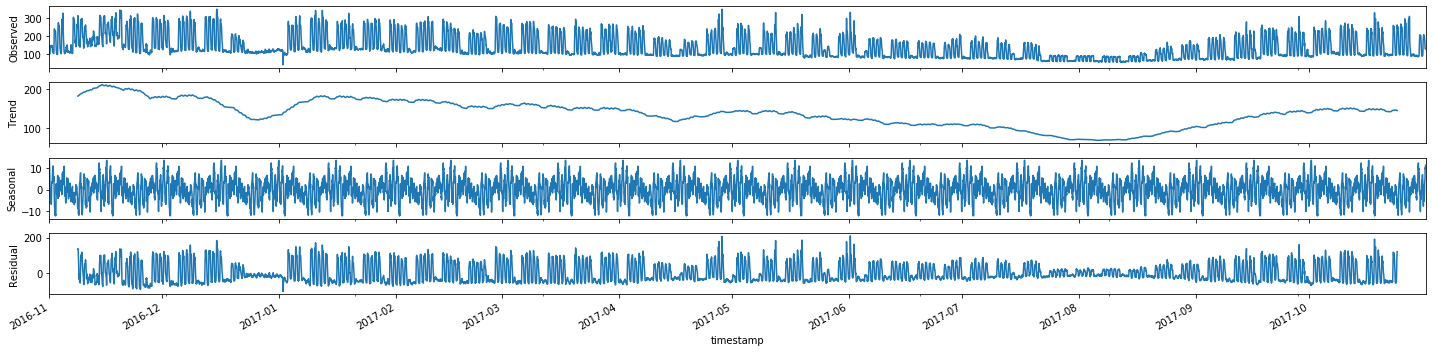

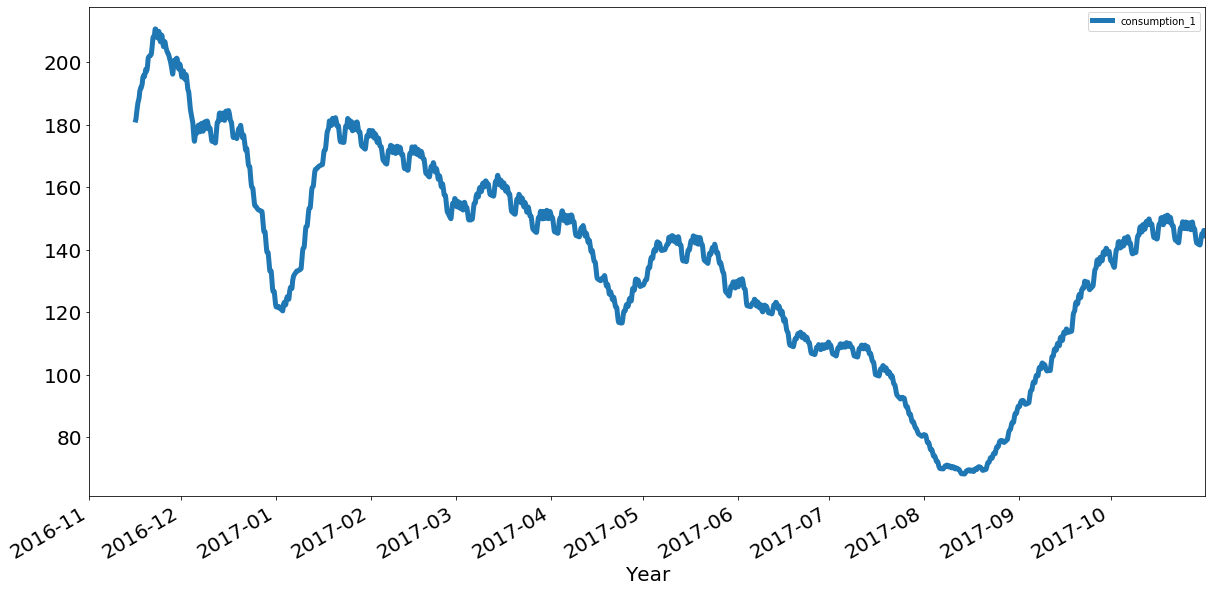

In [45]:
tsplot(data1['consumption_1'], title='consumption_1')
decomposition  =sm.tsa.seasonal_decompose(data1['consumption_1'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = data1[['consumption_1']]
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

**'consumption_1' --->differencing**

adf -> TS < critical => stationnary, pvalue stationary

kpss -> TS > critical => not stationnary


In [46]:
adf_test(data1['consumption_2'])
kpss_test(data1['consumption_2'])

Results of Dickey-Fuller Test:
Test Statistic                   -4.688609
p-value                           0.000088
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic            8.407722
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



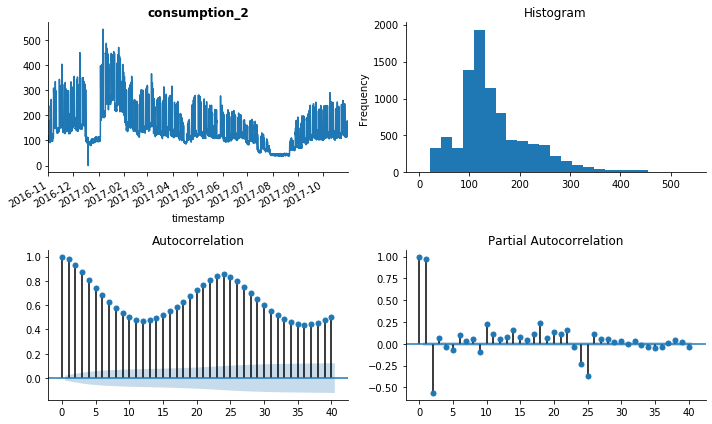

Text(0.5, 0, 'Year')

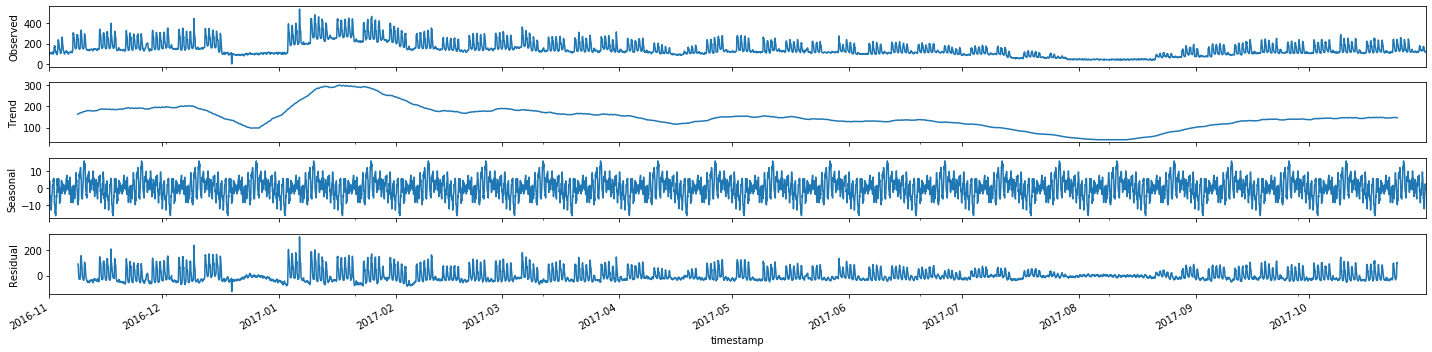

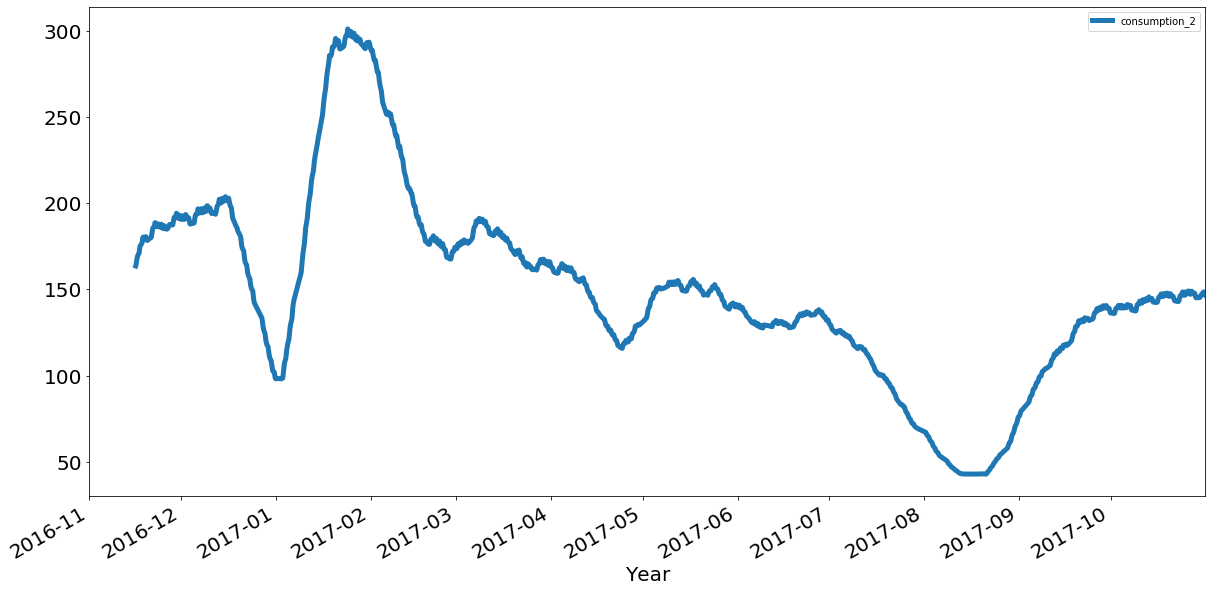

In [47]:
tsplot(data1['consumption_2'], title='consumption_2')
decomposition  =sm.tsa.seasonal_decompose(data1['consumption_2'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = data1[['consumption_2']]
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

c/c: tous differencing sauf moyenn enationale qui est full not stationnary

In [48]:
#visualisation
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss


def test_stationarity1(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
        
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    #perforn KSSP test:
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    
    


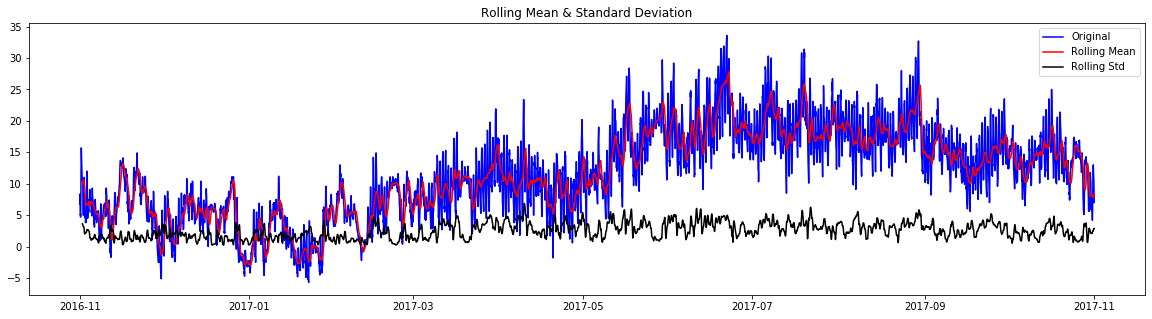

Results of Dickey-Fuller Test:
Test Statistic                   -3.565733
p-value                           0.006451
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           14.788216
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



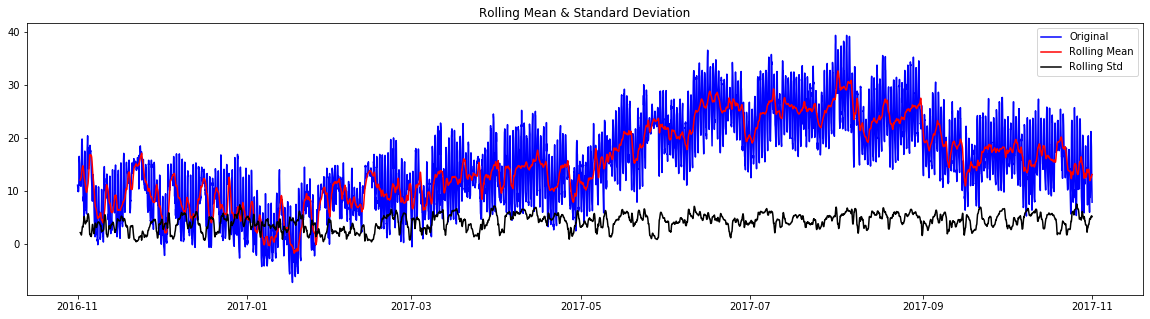

Results of Dickey-Fuller Test:
Test Statistic                   -3.368983
p-value                           0.012063
#Lags Used                       33.000000
Number of Observations Used    8726.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           14.317102
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



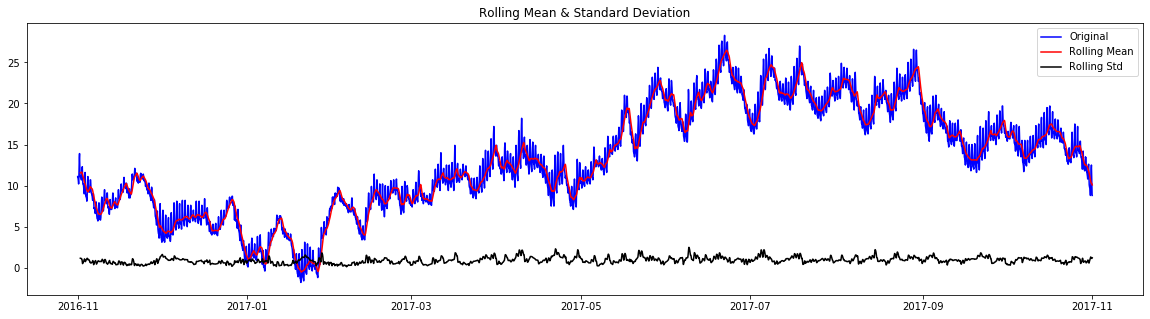

Results of Dickey-Fuller Test:
Test Statistic                   -2.307181
p-value                           0.169663
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic           15.766045
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



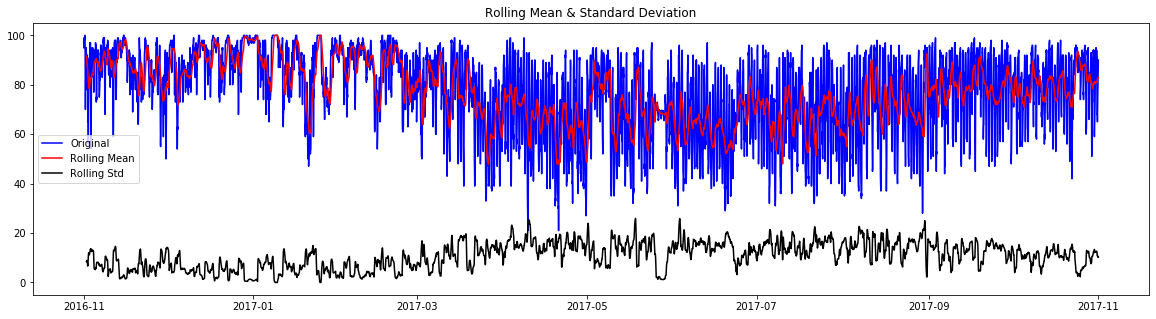

Results of Dickey-Fuller Test:
Test Statistic                -7.121628e+00
p-value                        3.709626e-10
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            7.234414
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



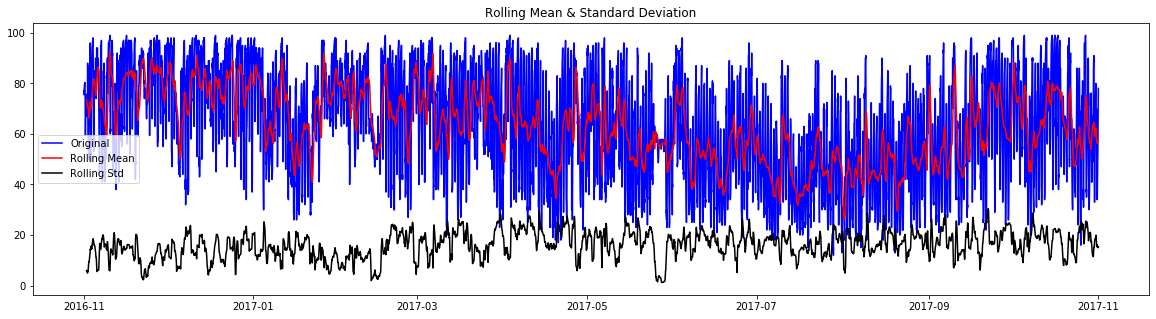

Results of Dickey-Fuller Test:
Test Statistic                -7.686862e+00
p-value                        1.453836e-11
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            8.448472
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



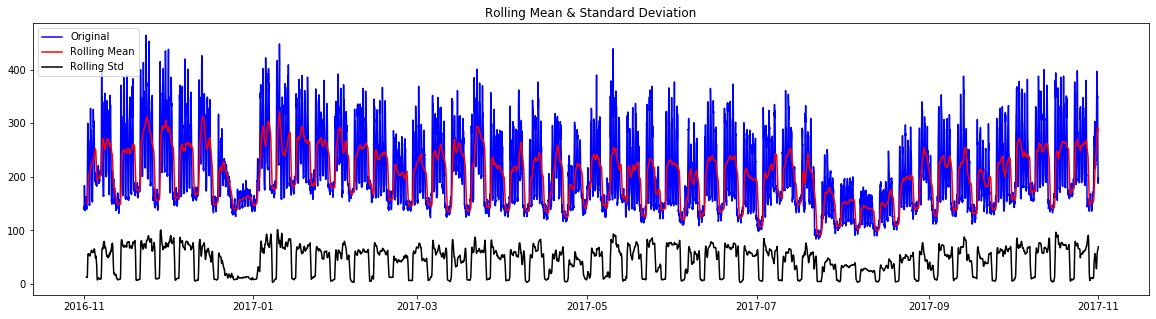

Results of Dickey-Fuller Test:
Test Statistic                -1.094177e+01
p-value                        9.257566e-20
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            2.509934
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



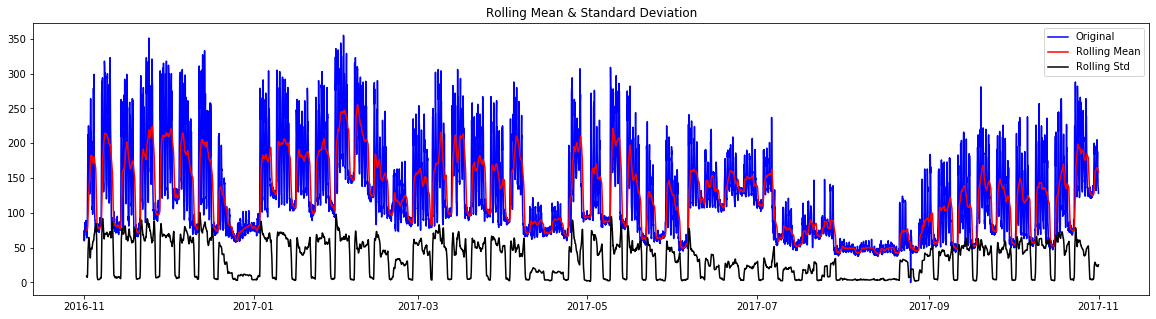

Results of Dickey-Fuller Test:
Test Statistic                -8.455478e+00
p-value                        1.619259e-13
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            5.074619
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



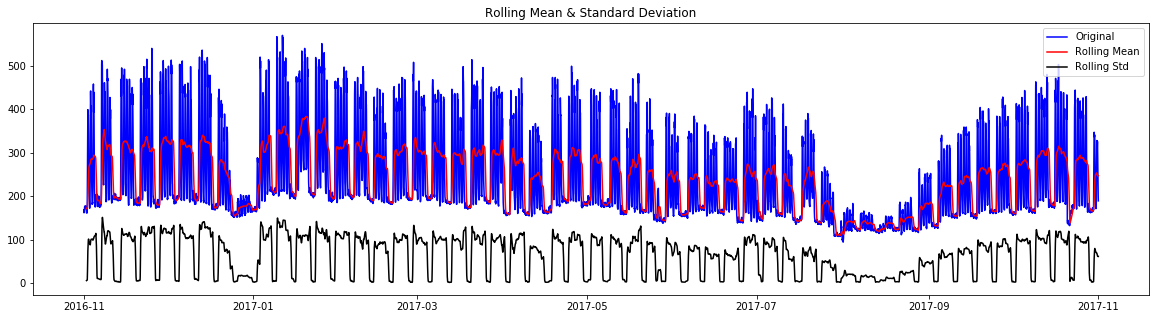

Results of Dickey-Fuller Test:
Test Statistic                -9.555919e+00
p-value                        2.499232e-16
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            5.220702
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



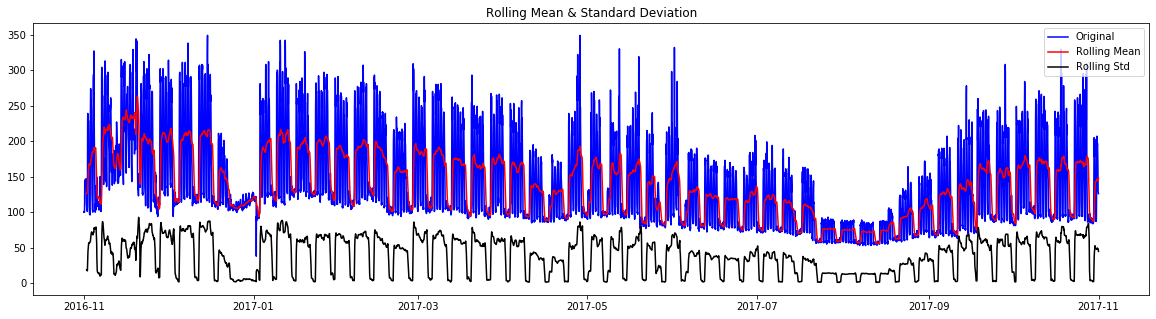

Results of Dickey-Fuller Test:
Test Statistic                -8.125894e+00
p-value                        1.123480e-12
#Lags Used                     3.700000e+01
Number of Observations Used    8.722000e+03
Critical Value (1%)           -3.431100e+00
Critical Value (5%)           -2.861871e+00
Critical Value (10%)          -2.566946e+00
dtype: float64
Results of KPSS Test:
Test Statistic            8.00514
p-value                   0.01000
Lags Used                37.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



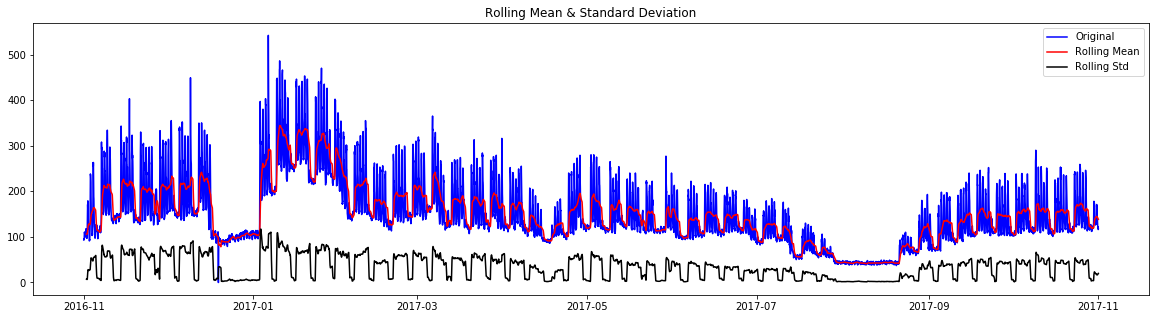

Results of Dickey-Fuller Test:
Test Statistic                   -4.688609
p-value                           0.000088
#Lags Used                       37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.431100
Critical Value (5%)              -2.861871
Critical Value (10%)             -2.566946
dtype: float64
Results of KPSS Test:
Test Statistic            8.407722
p-value                   0.010000
Lags Used                37.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1707: InterpolationWarning:

p-value is smaller than the indicated p-value



temp_1                     None
temp_2                     None
mean_national_temp         None
humidity_1                 None
humidity_2                 None
consumption_secondary_1    None
consumption_secondary_2    None
consumption_secondary_3    None
consumption_1              None
consumption_2              None
dtype: object

In [49]:
# Loop to check all columns of the DF
import functools
data1.apply(functools.partial(test_stationarity1))

In [50]:
print(data1.describe())

            temp_1       temp_2  mean_national_temp   humidity_1   humidity_2  \
count  8760.000000  8760.000000         8760.000000  8760.000000  8760.000000   
mean     11.575336    15.242838           13.173858    77.154757    63.283592   
std       7.093700     8.445449            6.474700    16.548010    21.640524   
min      -5.700000    -7.200000           -1.800000    21.000000    12.000000   
25%       6.100000     9.100000            8.200000    66.000000    46.000000   
50%      11.450000    14.700000           12.800000    81.000000    64.000000   
75%      16.700000    21.301837           18.700000    91.000000    82.000000   
max      33.600000    39.300000           28.300000   100.000000    99.000000   

       consumption_secondary_1  consumption_secondary_2  \
count              8760.000000              8760.000000   
mean                203.025114               123.581735   
std                  69.792811                65.036526   
min                  84.000000    

In [51]:
import statsmodels.api as sm
import matplotlib

Dickey-Fuller: Test statistic LESS critical value => stationnary

KSS : test statistic Greater critical value => non stationnary


    Case 1: Both tests conclude that the series is not stationary -> series is not stationary
    Case 2: Both tests conclude that the series is stationary -> series is stationary
    Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
    Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary


In [52]:
data1.columns

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

In [53]:
#checking stationarity
from statsmodels.tsa.vector_ar.vecm import coint_johansen

coint_johansen(data1,-1,1).eig

array([1.73173216e-01, 8.97830316e-02, 7.48613575e-02, 5.46035161e-02,
       4.63873002e-02, 3.96436843e-02, 3.31423493e-02, 1.56245056e-02,
       3.49832005e-03, 9.86047355e-05])

differencing

In [54]:
data1.describe()

temp_1       temp_2  mean_national_temp   humidity_1   humidity_2  \
count  8760.000000  8760.000000         8760.000000  8760.000000  8760.000000   
mean     11.575336    15.242838           13.173858    77.154757    63.283592   
std       7.093700     8.445449            6.474700    16.548010    21.640524   
min      -5.700000    -7.200000           -1.800000    21.000000    12.000000   
25%       6.100000     9.100000            8.200000    66.000000    46.000000   
50%      11.450000    14.700000           12.800000    81.000000    64.000000   
75%      16.700000    21.301837           18.700000    91.000000    82.000000   
max      33.600000    39.300000           28.300000   100.000000    99.000000   

       consumption_secondary_1  consumption_secondary_2  \
count              8760.000000              8760.000000   
mean                203.025114               123.581735   
std                  69.792811                65.036526   
min                  84.000000                 0.000000   
25%                 150.000000                73.000000   
50%                 181.000000               107.000000   
75%                 252.000000               160.000000   
max                 464.000000               355.000000   

       consumption_secondary_3  consumption_1  consumption_2  
count              8760.000000    8760.000000    8760.000000  
mean                235.774201     137.549543     148.529909  
std                  99.701896      63.146689      73.263972  
min                  94.000000      38.000000       0.000000  
25%                 166.000000      91.000000     105.000000  
50%                 194.000000     116.000000     129.000000  
75%                 287.250000     176.000000     181.000000  
max                 570.000000     349.000000     542.000000

In [55]:
def DeckeyFuller(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries.iloc[:, 0].values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [56]:
trans = data1.copy()

In [57]:
trans.columns

Index(['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3', 'consumption_1', 'consumption_2'],
      dtype='object')

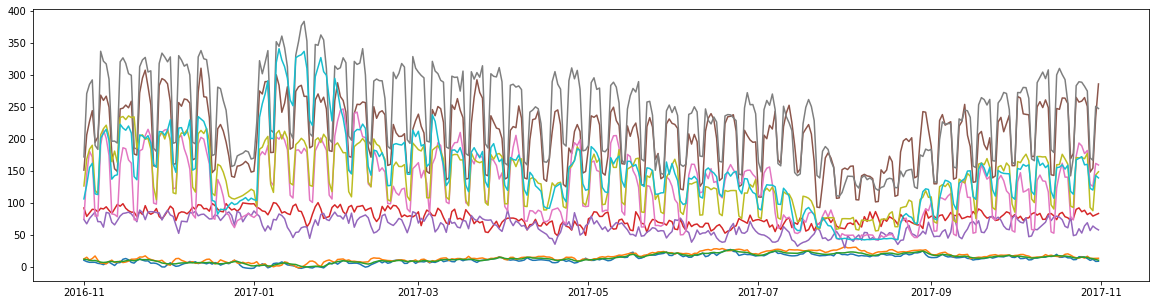

In [58]:
resamp = trans.resample('D').mean()
plt.plot(resamp)

In [59]:
resamp.head(2)

temp_1     temp_2  mean_national_temp  humidity_1  humidity_2  \
timestamp                                                                     
2016-11-01  9.912500  12.037154           11.558333   91.625000   73.608135   
2016-11-02  7.916667  14.716442           11.062500   78.416667   66.878504   

            consumption_secondary_1  consumption_secondary_2  \
timestamp                                                      
2016-11-01                   150.75                74.625000   
2016-11-02                   205.75               144.208333   

            consumption_secondary_3  consumption_1  consumption_2  
timestamp                                                          
2016-11-01               171.416667     126.041667     105.833333  
2016-11-02               270.250000     167.708333     127.583333

In [60]:
adf_test(resamp['temp_1'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.057861
p-value                          0.261793
#Lags Used                       4.000000
Number of Observations Used    360.000000
Critical Value (1%)             -3.448646
Critical Value (5%)             -2.869602
Critical Value (10%)            -2.571065
dtype: float64


In [61]:
resamp['temp_1_diff'] = pd.Series(resamp['temp_1'].diff(1).dropna())
resamp['temp_1_diff'].dropna(inplace=True)
adf_test(resamp['temp_1_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -1.287212e+01
p-value                        4.854402e-24
#Lags Used                     3.000000e+00
Number of Observations Used    3.600000e+02
Critical Value (1%)           -3.448646e+00
Critical Value (5%)           -2.869602e+00
Critical Value (10%)          -2.571065e+00
dtype: float64


In [62]:
adf_test(resamp['temp_2'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.325321
p-value                          0.617510
#Lags Used                      15.000000
Number of Observations Used    349.000000
Critical Value (1%)             -3.449227
Critical Value (5%)             -2.869857
Critical Value (10%)            -2.571201
dtype: float64


In [63]:
resamp['temp_2_diff'] = pd.Series(resamp['temp_2'].diff(1).dropna())
resamp['temp_2_diff'].dropna(inplace=True)
adf_test(resamp['temp_2_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -7.311568e+00
p-value                        1.260371e-10
#Lags Used                     1.300000e+01
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [64]:
adf_test(resamp['humidity_1'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.062121
p-value                          0.260016
#Lags Used                       9.000000
Number of Observations Used    355.000000
Critical Value (1%)             -3.448906
Critical Value (5%)             -2.869716
Critical Value (10%)            -2.571126
dtype: float64


In [65]:
resamp['humidity_1_diff'] = pd.Series(resamp['humidity_1'].diff(1).dropna())
resamp['humidity_1_diff'].dropna(inplace=True)
adf_test(resamp['humidity_1_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -1.014324e+01
p-value                        8.313560e-18
#Lags Used                     8.000000e+00
Number of Observations Used    3.550000e+02
Critical Value (1%)           -3.448906e+00
Critical Value (5%)           -2.869716e+00
Critical Value (10%)          -2.571126e+00
dtype: float64


In [66]:
adf_test(resamp['humidity_2'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.439396
p-value                          0.130924
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


In [67]:
resamp['humidity_2_diff'] = pd.Series(resamp['humidity_2'].diff(1).dropna())
resamp['humidity_2_diff'].dropna(inplace=True)
adf_test(resamp['humidity_2_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -1.245234e+01
p-value                        3.552467e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


In [68]:
adf_test(resamp['consumption_secondary_1'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.635687
p-value                          0.085843
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


In [69]:
resamp['consumption_secondary_1_diff'] = pd.Series(resamp['consumption_secondary_1'].diff(1).dropna())
resamp['consumption_secondary_1_diff'].dropna(inplace=True)
adf_test(resamp['consumption_secondary_1_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -5.992952e+00
p-value                        1.728193e-07
#Lags Used                     1.300000e+01
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [70]:
adf_test(resamp['consumption_secondary_2'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.934763
p-value                          0.041452
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


In [71]:
resamp['consumption_secondary_2_diff'] = pd.Series(resamp['consumption_secondary_2'].diff(1).dropna())
resamp['consumption_secondary_2_diff'].dropna(inplace=True)
adf_test(resamp['consumption_secondary_2_diff'])

Results of Dickey-Fuller Test:
Test Statistic                  -5.519403
p-value                          0.000002
#Lags Used                      13.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


In [72]:
adf_test(resamp['consumption_secondary_3'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.129826
p-value                          0.232692
#Lags Used                      14.000000
Number of Observations Used    350.000000
Critical Value (1%)             -3.449173
Critical Value (5%)             -2.869833
Critical Value (10%)            -2.571188
dtype: float64


In [73]:
resamp['consumption_secondary_3_diff'] = pd.Series(resamp['consumption_secondary_3'].diff(1).dropna())
resamp['consumption_secondary_3_diff'].dropna(inplace=True)
adf_test(resamp['consumption_secondary_3_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -5.965242e+00
p-value                        1.994956e-07
#Lags Used                     1.300000e+01
Number of Observations Used    3.500000e+02
Critical Value (1%)           -3.449173e+00
Critical Value (5%)           -2.869833e+00
Critical Value (10%)          -2.571188e+00
dtype: float64


In [74]:
adf_test(resamp['consumption_1'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.918604
p-value                          0.323360
#Lags Used                      13.000000
Number of Observations Used    351.000000
Critical Value (1%)             -3.449119
Critical Value (5%)             -2.869810
Critical Value (10%)            -2.571176
dtype: float64


In [75]:
resamp['consumption_1_diff'] = pd.Series(resamp['consumption_1'].diff(1).dropna())
resamp['consumption_1_diff'].dropna(inplace=True)
adf_test(resamp['consumption_1_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -8.005710e+00
p-value                        2.270757e-12
#Lags Used                     1.200000e+01
Number of Observations Used    3.510000e+02
Critical Value (1%)           -3.449119e+00
Critical Value (5%)           -2.869810e+00
Critical Value (10%)          -2.571176e+00
dtype: float64


In [76]:
adf_test(resamp['consumption_2'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.519724
p-value                          0.110749
#Lags Used                      17.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [77]:
resamp['consumption_2_diff'] = pd.Series(resamp['consumption_2'].diff(1).dropna())
resamp['consumption_2_diff'].dropna(inplace=True)
adf_test(resamp['consumption_2_diff'])

Results of Dickey-Fuller Test:
Test Statistic                  -4.840359
p-value                          0.000045
#Lags Used                      16.000000
Number of Observations Used    347.000000
Critical Value (1%)             -3.449337
Critical Value (5%)             -2.869906
Critical Value (10%)            -2.571227
dtype: float64


In [78]:
adf_test(resamp['mean_national_temp'])

Results of Dickey-Fuller Test:
Test Statistic                  -1.085934
p-value                          0.720649
#Lags Used                      12.000000
Number of Observations Used    352.000000
Critical Value (1%)             -3.449065
Critical Value (5%)             -2.869786
Critical Value (10%)            -2.571163
dtype: float64


In [79]:
resamp['mean_national_temp_diff'] = pd.Series(resamp['mean_national_temp'].diff(1).dropna())
resamp['mean_national_temp_diff'].dropna(inplace=True)
adf_test(resamp['mean_national_temp_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -7.382987e+00
p-value                        8.377384e-11
#Lags Used                     1.100000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64


In [80]:
resamp.dropna(inplace = True)

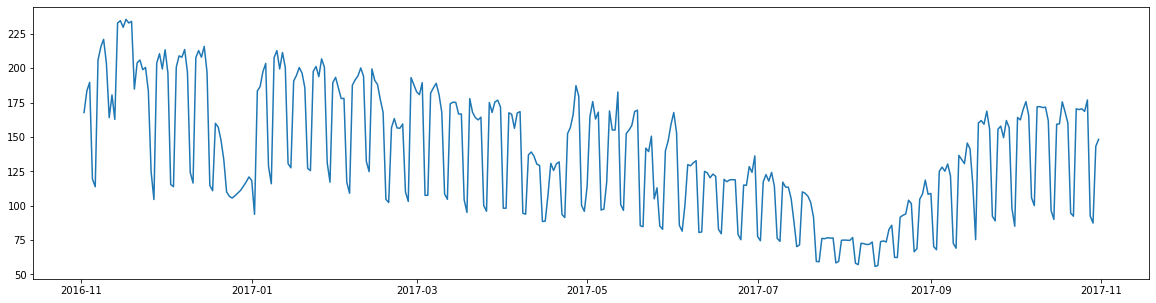

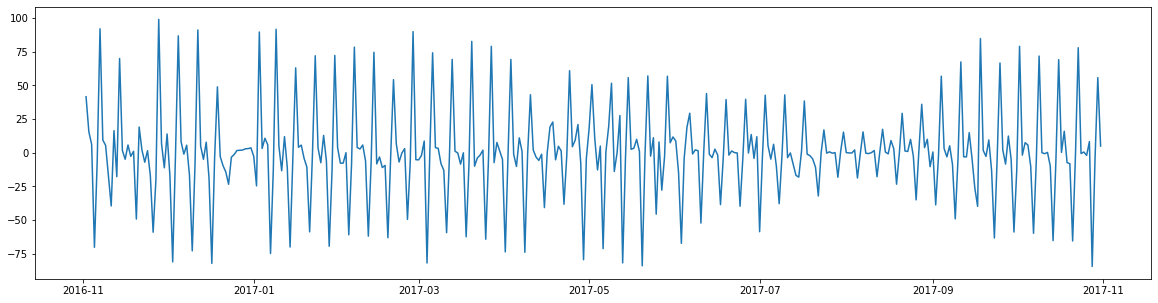

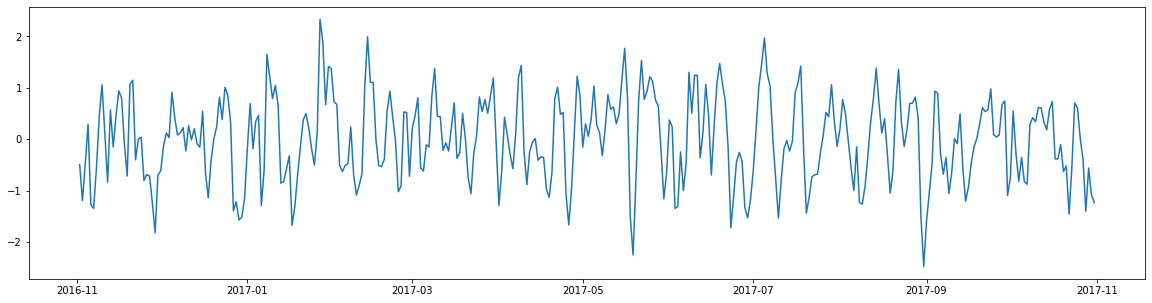

In [81]:
# check_plots(resamp['temp_1'])
check_plots(resamp['consumption_1'])
check_plots(resamp['consumption_1_diff'])
check_plots(resamp['mean_national_temp_diff'])

In [82]:
check_summary(resamp['consumption_1'])

mean overall = 137.582142, 	 mean1=160.600952, 	 mean2=114.563333
variance overall= 1990.621834, 	 variance1=1624.692568, 	 variance2=1296.819953


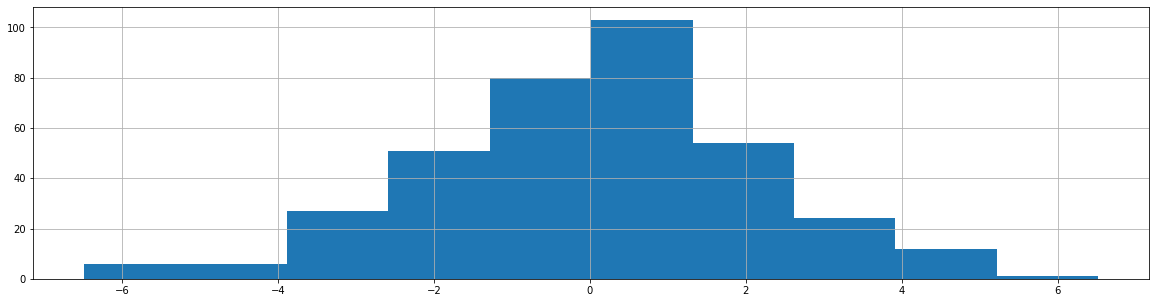

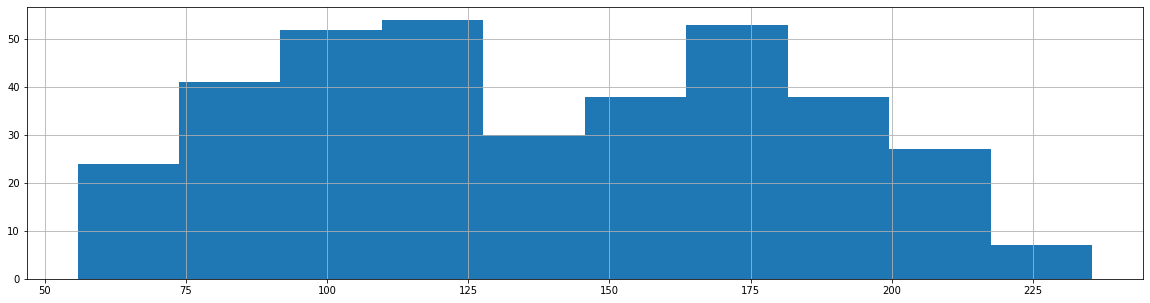

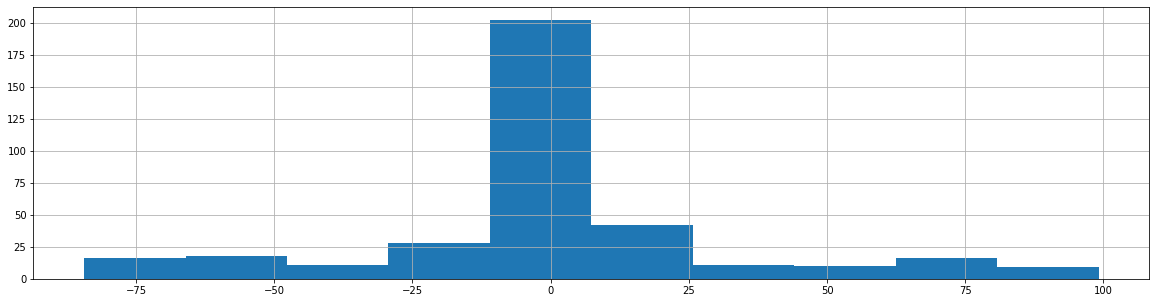

In [83]:
check_distribution(resamp['temp_1_diff'])
check_distribution(resamp['consumption_1'])
check_distribution(resamp['consumption_1'].diff(1).dropna())

In [84]:
check_stationarity(resamp['consumption_1'])

Test: Running ADF Stationarity test for consumption_1 
	 ADF test statistic: -1.9583349021425807 
	 p-value: 0.3051351171042711 

	Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
	 Conclusion: Series is non-stationary



'Series is non-Stationary'

In [85]:
check_stationarity(resamp['consumption_1_diff'])

Test: Running ADF Stationarity test for consumption_1_diff 
	 ADF test statistic: -8.005709737646729 
	 p-value: 2.270757300788379e-12 

	Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
	 Conclusion: Series is stationary at 95% CI



'Series is Stationary @95% CI'

In [86]:
check_stationarity(resamp['mean_national_temp_diff'])

Test: Running ADF Stationarity test for mean_national_temp_diff 
	 ADF test statistic: -7.382987340950096 
	 p-value: 8.3773836140493e-11 

	Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
	 Conclusion: Series is stationary at 95% CI



'Series is Stationary @95% CI'

In [87]:
adf_test(resamp['mean_national_temp_diff'])
kpss_test(resamp['mean_national_temp_diff'])

Results of Dickey-Fuller Test:
Test Statistic                -7.382987e+00
p-value                        8.377384e-11
#Lags Used                     1.100000e+01
Number of Observations Used    3.520000e+02
Critical Value (1%)           -3.449065e+00
Critical Value (5%)           -2.869786e+00
Critical Value (10%)          -2.571163e+00
dtype: float64
Results of KPSS Test:
Test Statistic            0.18985
p-value                   0.10000
Lags Used                17.00000
Critical Value (10%)      0.34700
Critical Value (5%)       0.46300
Critical Value (2.5%)     0.57400
Critical Value (1%)       0.73900
dtype: float64


/home/anthelix/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning:

p-value is greater than the indicated p-value



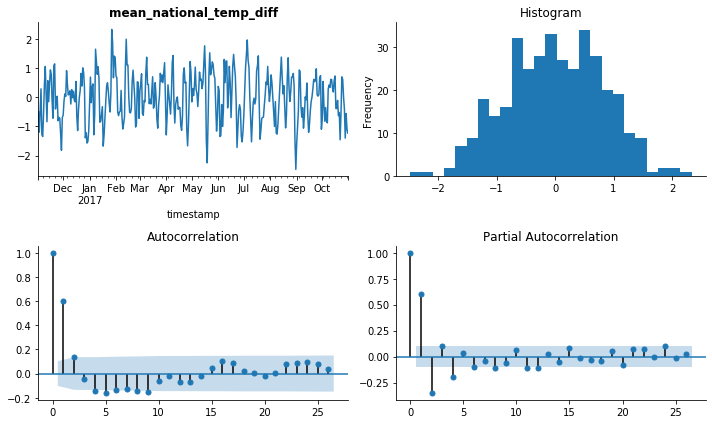

ValueError: operands could not be broadcast together with shapes (364,) (366,) 

In [88]:
tsplot(resamp['mean_national_temp_diff'], title='mean_national_temp_diff')
decomposition  =sm.tsa.seasonal_decompose(resamp['mean_national_temp_diff'], freq=365, model = 'additive')
fig= decomposition.plot()
matplotlib.rcParams['figure.figsize'] = [20, 5.0]
cons = resamp['mean_national_temp_diff']
cons.rolling(365).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20)

In [92]:
temp_data = pd.DataFrame(resamp).dropna()
model_data = temp_data[['temp_1', 'temp_2', 'mean_national_temp', 'humidity_1', 'humidity_2',
       'consumption_secondary_1', 'consumption_secondary_2',
       'consumption_secondary_3']]

Exogenous Variables for the model with Lag: 1 
 ['const', 'L1.temp_1', 'L1.temp_2', 'L1.mean_national_temp', 'L1.humidity_1', 'L1.humidity_2', 'L1.consumption_secondary_1', 'L1.consumption_secondary_2', 'L1.consumption_secondary_3']
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 14, Jul, 2019
Time:                     01:52:54
--------------------------------------------------------------------
No. of Equations:         8.00000    BIC:                    28.4207
Nobs:                     363.000    HQIC:                   27.9553
Log likelihood:          -9066.76    FPE:                1.01749e+12
AIC:                      27.6483    Det(Omega_mle):     8.36451e+11
--------------------------------------------------------------------
Results for equation temp_1
                                coefficient       std. error           t-stat            prob
--------------------------------------------------------

************* Running Stationarity and Normality for the Residuals *************

Test: Running Agostino and Pearson Normality test for Residuals_temp_1 
	 Normality test statistic: 0.18744773561605052 
	 p-value: 0.9105341553224853 
	 Conclusion: Residuals_temp_1 is normally distributed at 95% CI 

Test: Running ADF Stationarity test for Residuals_temp_1 
	 ADF test statistic: -10.573435065534152 
	 p-value: 7.206426583107556e-19 

	Critical Values:
	1%: -3.449
	5%: -2.870
	10%: -2.571
	 Conclusion: Series is stationary at 95% CI



NameError: name 'acf' is not defined

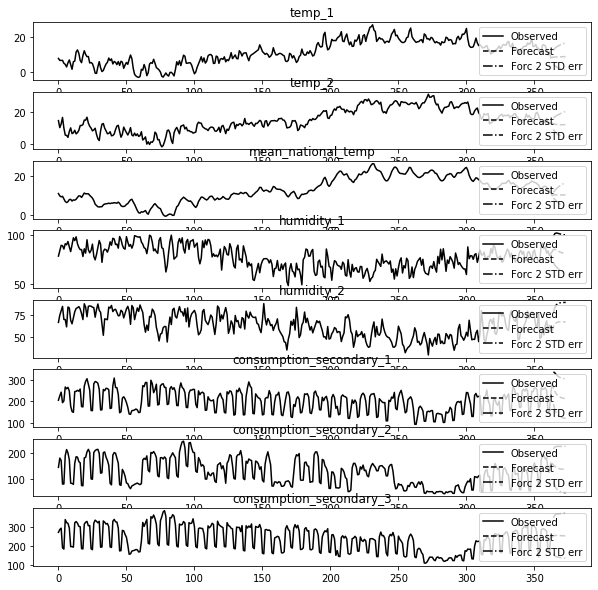

In [97]:
from statsmodels.tsa.api import VAR, DynamicVAR
from scipy import stats
def make_var_model(data, lags = 1, actual_plot = False ):
 
    # make a VAR model
    model = VAR(data)
    
    result_dict = {}

        
    for lag in range(1, lags+1):
        #Fitting Model
        results = model.fit(maxlags = lag)
        
        lag_order = results.k_ar
        
        print ('Exogenous Variables for the model with Lag: %d \n '%lag+ str(results.exog_names))
        print (results.summary())
        
        #Generating Model output
        fitted_values = results.fittedvalues
        forecast_values = pd.DataFrame(data = results.forecast(y= data.values[-lag_order:], steps=  5), columns = results.names)
        results.forecast_interval(y= data.values[-lag_order:], steps = 10)
        
        results.plot_forecast(steps = 10, plot_stderr = True)
        
        if actual_plot ==True:
            results.plot()

        #Storing Residuals for testing purpose
        residuals = results.resid.add_prefix('Residuals_')
        normality_var = {}
        stationarity_var = {}
        acf_data = {}
        
        print("************* Running Stationarity and Normality for the Residuals *************\n")  
        for column in residuals.columns:
            #test for normality of residuals
            normality_var[column] = check_normality(residuals[column])
            #test for stationarity of residuals
            stationarity_var[column] = check_stationarity(residuals[column])
            #acf plots of residuals of each variable for 10 lags
            acf_data[column] = acf(residuals[column])[0:10]       
        
         
        
        result_dict['Lag_Order_{}'.format(lag_order)] = equation_model_data
                   
    return result_dict

#make_var_model(data = mdata1, lags = 1, actual_plot = False )
    
Results = make_var_model(data = model_data, lags = 2, actual_plot = False )

In [ ]:
# Creating the VAR model
from statsmodels.tsa.vector_ar.var_model import VAR

model = VAR(dataDiff)

In [ ]:
# Best model order
modsel = model.select_order(15)
modsel.summary()

In [ ]:
# Automated model order selection
results = model.fit(maxlags=15, ic='aic')
results.summary()

In [ ]:
grangres = results.test_causality('consumption_1', ['temp_1', 'mean_national_temp', 'humidity_1'], kind='f')
grangres.summary